<h3> Anmol More – 11915043
<br><br>
Sriganesh Balamurugan – 11915001
<br><br>
Raghu Punnamraju – 11915010
<br>
<br>

#-----------------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN
from imblearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import adam
import tensorflow as tf

import seaborn as sn
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
#read provider and beneficiary data files
beneficiary = pd.read_csv('Beneficiarydatafile.csv')
provider = pd.read_csv('Provider_Dataset.csv')

#remove claim id from columns
provider = provider.loc[:, provider.columns != 'Claim_ID']
#remove ClmProcedureCode_6 as all columns are blank
provider = provider.loc[:, provider.columns != 'ClmProcedureCode_6']

train_dataset = pd.read_excel('Train_Dataset.xlsx')
test_dataset = pd.read_excel('Test_Dataset.xlsx')

In [3]:
print("beneficiary dataset size : ", beneficiary.shape)
print("Provider dataset size : ", provider.shape)
print("Train dataset size : ", train_dataset.shape)
print("Test dataset size : ", test_dataset.shape)

beneficiary dataset size :  (138556, 25)
Provider dataset size :  (558211, 29)
Train dataset size :  (3998, 2)
Test dataset size :  (1412, 1)


## Feature Engineering

### Provider Data

In [4]:
#change string to date types
provider['Claim_Start_Date'] = pd.to_datetime(provider['Claim_Start_Date'], format='%d-%m-%Y')
provider['Claim_End_Date'] = pd.to_datetime(provider['Claim_End_Date'], format='%d-%m-%Y')

#fill missing admission and discharge dates
provider['AdmissionDate'] =  pd.to_datetime(provider['AdmissionDate'], format='%d-%m-%Y')
provider['Discharge_date'] = pd.to_datetime(provider['Discharge_date'], format='%d-%m-%Y')

#Fill all missing Admission date and discharge date with claim start and end
provider['AdmissionDate'].fillna(provider['Claim_Start_Date'], inplace=True)
provider['Discharge_date'].fillna(provider['Claim_End_Date'], inplace=True)

provider['Days stayed'] = (provider['Discharge_date'] - provider['AdmissionDate']).dt.days
provider['Days in claim'] = (provider['Claim_End_Date'] - provider['Claim_Start_Date']).dt.days
provider['Days Admission to Claim'] = (provider['Claim_Start_Date'] - provider['AdmissionDate']).dt.days

#drop date columns once done
#provider.drop(columns=['Claim_Start_Date', 'Claim_End_Date', 'Discharge_date'], inplace=True)

In [5]:
#Fill missing operating physician with other physcian
provider['OperatingPhysician'].fillna(provider['OtherPhysician'], inplace=True)
provider['Attended_Physician'].fillna(provider['OperatingPhysician'], inplace=True)

#Fill backwards, as attending, operating, other physician could be same
provider['OperatingPhysician'].fillna(provider['Attended_Physician'], inplace=True)
provider['OperatingPhysician'].fillna(provider['OtherPhysician'], inplace=True)

provider['OtherPhysician'].fillna(provider['Attended_Physician'], inplace=True)
provider['OtherPhysician'].fillna(provider['OperatingPhysician'], inplace=True)

#Create a category "NA" for all missing physcian details
provider['Attended_Physician'].fillna('NA', inplace=True)
provider['OperatingPhysician'].fillna('NA', inplace=True)
provider['OtherPhysician'].fillna('NA', inplace=True)

#fill missing deductible amount paid, highly correlated to patient type, almost a correlation of 1
#all missing Deductible_Amount_Paid has patient type 0, ie value 1068
provider['Deductible_Amount_Paid'].fillna(1068, inplace=True)

#count no of diagnosis and no of procedures
provider['Diagnosis Count'] = provider[['ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3','ClmDiagnosisCode_4',
                         'ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7','ClmDiagnosisCode_8',
                         'ClmDiagnosisCode_9','ClmDiagnosisCode_10']].notnull().sum(axis=1)
provider['Procedure Count'] = provider[['ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3',
                         'ClmProcedureCode_4','ClmProcedureCode_5']].notnull().sum(axis=1)

In [6]:
#Check count of null values in each of columns
print(provider.isna().sum())

provider = provider[['Beneficiary_ID',
                     'Deductible_Amount_Paid', 'Insurance_Amount_Reimbursed',
                     'Attended_Physician', 'OperatingPhysician', 'OtherPhysician',
                     'PatientType',
                     'Provider_Hospital',
                     'Days stayed', 'Days in claim', 'Days Admission to Claim',
                     'Diagnosis Count','Procedure Count',
                     'AdmissionDate']]

AdmissionDate                       0
Attended_Physician                  0
Beneficiary_ID                      0
Claim_End_Date                      0
Claim_Start_Date                    0
Clm_Admit_Code                 412312
ClmDiagnosisCode_1              10453
ClmDiagnosisCode_10            553201
ClmDiagnosisCode_2             195606
ClmDiagnosisCode_3             315156
ClmDiagnosisCode_4             393675
ClmDiagnosisCode_5             446287
ClmDiagnosisCode_6             473819
ClmDiagnosisCode_7             492034
ClmDiagnosisCode_8             504767
ClmDiagnosisCode_9             516396
ClmProcedureCode_1             534901
ClmProcedureCode_2             552721
ClmProcedureCode_3             557242
ClmProcedureCode_4             558093
ClmProcedureCode_5             558202
Deductible_Amount_Paid              0
Diagnosis_Group_Code           517737
Discharge_date                      0
Insurance_Amount_Reimbursed         0
OperatingPhysician                  0
OtherPhysici

### Beneficiary data

In [7]:
beneficiary.sample(5)

,Beneficiary_ID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
99608,BENE117561,01-05-1981,NaN,2,1,0,34,120,12,12,...,1,1,1,1,1,2,24440,2136,600,500
31363,BENE44614,01-09-1924,NaN,2,2,0,23,120,12,12,...,1,1,1,2,1,2,27000,3204,90,40
54118,BENE68958,01-07-1920,NaN,1,1,0,22,70,12,12,...,2,1,2,1,1,2,0,0,2820,780
30175,BENE43348,01-03-1934,NaN,2,1,0,22,40,12,12,...,1,2,2,1,2,2,0,0,390,200
26635,BENE39540,01-06-1931,01-06-2009,1,3,0,46,170,12,12,...,2,1,2,1,1,2,0,0,50,0


In [8]:
#create died columnn
beneficiary['DOD'] = beneficiary['DOD'].fillna(0)
beneficiary['Died'] = beneficiary['DOD'].astype(bool).astype(int)
beneficiary.drop(columns=['DOD'], inplace=True)

#convert Y to 1 and all 2s to 0
beneficiary.loc[beneficiary['RenalDiseaseIndicator'] == 'Y', 'RenalDiseaseIndicator'] = 1
beneficiary.loc[beneficiary['ChronicCond_Alzheimer'] == 2, 'ChronicCond_Alzheimer'] = 0
beneficiary.loc[beneficiary['ChronicCond_Heartfailure'] == 2, 'ChronicCond_Heartfailure'] = 0
beneficiary.loc[beneficiary['ChronicCond_KidneyDisease'] == 2, 'ChronicCond_KidneyDisease'] = 0
beneficiary.loc[beneficiary['ChronicCond_Cancer'] == 2, 'ChronicCond_Cancer'] = 0
beneficiary.loc[beneficiary['ChronicCond_ObstrPulmonary'] == 2, 'ChronicCond_ObstrPulmonary'] = 0
beneficiary.loc[beneficiary['ChronicCond_Depression'] == 2, 'ChronicCond_Depression'] = 0
beneficiary.loc[beneficiary['ChronicCond_Diabetes'] == 2, 'ChronicCond_Diabetes'] = 0
beneficiary.loc[beneficiary['ChronicCond_IschemicHeart'] == 2, 'ChronicCond_IschemicHeart'] = 0
beneficiary.loc[beneficiary['ChronicCond_Osteoporasis'] == 2, 'ChronicCond_Osteoporasis'] = 0
beneficiary.loc[beneficiary['ChronicCond_rheumatoidarthritis'] == 2, 'ChronicCond_rheumatoidarthritis'] = 0
beneficiary.loc[beneficiary['ChronicCond_stroke'] == 2, 'ChronicCond_stroke'] = 0

beneficiary['Disease Count'] = beneficiary[['RenalDiseaseIndicator','ChronicCond_Alzheimer','ChronicCond_Heartfailure',
                                         'ChronicCond_KidneyDisease','ChronicCond_Cancer','ChronicCond_ObstrPulmonary',
                                         'ChronicCond_Depression','ChronicCond_Diabetes','ChronicCond_IschemicHeart',
                                         'ChronicCond_Osteoporasis','ChronicCond_rheumatoidarthritis',
                                         'ChronicCond_stroke']].sum(axis=1)

### Prepare Dataset for Analysis

In [9]:
print(provider.shape)
print(beneficiary.shape)

#Provider IDs are important to retain
#There are claims for which we don't have beneficiary data available
data = pd.merge(provider, beneficiary, on='Beneficiary_ID', how='left')
print(data.shape)

(558211, 14)
(138556, 26)
(558211, 39)


#### Calculate age as on admission date

In [10]:
data['Age']  = round(((pd.to_datetime(data['AdmissionDate']) - pd.to_datetime(data['DOB'])).dt.days)/365.25, 0)
data.drop(columns=['Beneficiary_ID','AdmissionDate','DOB'], inplace=True)

In [11]:
data.describe()

,Deductible_Amount_Paid,Insurance_Amount_Reimbursed,PatientType,Days stayed,Days in claim,Days Admission to Claim,Diagnosis Count,Procedure Count,Gender,Race,...,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Died,Disease Count,Age
count,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,...,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000
mean,80.014804,997.012133,0.927493,1.728296,1.727940,0.000423,3.010897,0.053557,1.578838,1.255011,...,0.317647,0.311171,0.101720,5227.971466,568.756807,2278.225348,649.698745,0.007400,4.498616,73.734016
std,276.656578,3821.534891,0.259325,4.906075,4.904984,0.083884,2.448213,0.280534,0.493746,0.717437,...,0.465562,0.462973,0.302279,11786.274732,1179.172616,3881.846386,1002.020811,0.085707,2.332301,13.019976
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,-8000.000000,0.000000,-70.000000,0.000000,0.000000,0.000000,26.000000
25%,0.000000,40.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,460.000000,120.000000,0.000000,3.000000,68.000000
50%,0.000000,80.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1170.000000,340.000000,0.000000,5.000000,75.000000
75%,0.000000,300.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000,2.000000,1.000000,...,1.000000,1.000000,0.000000,6000.000000,1068.000000,2590.000000,790.000000,0.000000,6.000000,82.000000
max,1068.000000,125000.000000,1.000000,35.000000,36.000000,28.000000,10.000000,5.000000,2.000000,5.000000,...,1.000000,1.000000,1.000000,161470.000000,38272.000000,102960.000000,13840.000000,1.000000,11.000000,101.000000


#### Aggregation on Provider Level

In [12]:
df = pd.DataFrame(index = data.Provider_Hospital.unique())
df['Total Deductible Amount'] = data.groupby(['Provider_Hospital'])['Deductible_Amount_Paid'].agg('sum')
df['Avg Deductible Amount'] = data.groupby(['Provider_Hospital'])['Deductible_Amount_Paid'].agg('mean')
df['Total Insurance Amount'] = data.groupby(['Provider_Hospital'])['Insurance_Amount_Reimbursed'].agg('sum')
df['Avg Insurance Amount'] = data.groupby(['Provider_Hospital'])['Insurance_Amount_Reimbursed'].agg('mean')

df['Avg Days Stayed'] = data.groupby(['Provider_Hospital'])['Days stayed'].agg('mean')
df['Avg Days in claim'] = data.groupby(['Provider_Hospital'])['Days in claim'].agg('mean')
df['Avg Days Admission to Claim'] = data.groupby(['Provider_Hospital'])['Days Admission to Claim'].agg('mean')

#beneficiary related features
df['Avg Age'] = data.groupby(['Provider_Hospital'])['Age'].agg('mean')

df['Avg Diagnosis Count'] = data.groupby(['Provider_Hospital'])['Diagnosis Count'].agg('mean')
df['Avg Procedure Count'] = data.groupby(['Provider_Hospital'])['Procedure Count'].agg('mean')

df['Avg Months PartA Cov'] = data.groupby(['Provider_Hospital'])['NoOfMonths_PartACov'].agg('mean')
df['Avg Months PartB Cov'] = data.groupby(['Provider_Hospital'])['NoOfMonths_PartBCov'].agg('mean')

df['Avg IP ReimbursementAmt'] = data.groupby(['Provider_Hospital'])['IPAnnualReimbursementAmt'].agg('mean')
df['Avg OP ReimbursementAmt'] = data.groupby(['Provider_Hospital'])['OPAnnualReimbursementAmt'].agg('mean')

df['Avg IP DeductibleAmt'] = data.groupby(['Provider_Hospital'])['IPAnnualDeductibleAmt'].agg('mean')
df['Avg OP DeductibleAmt'] = data.groupby(['Provider_Hospital'])['OPAnnualDeductibleAmt'].agg('mean')

df['Avg Disease Count'] = data.groupby(['Provider_Hospital'])['Disease Count'].agg('mean')

df['Provider'] = df.index
df.sample(5)

,Total Deductible Amount,Avg Deductible Amount,Total Insurance Amount,Avg Insurance Amount,Avg Days Stayed,Avg Days in claim,Avg Days Admission to Claim,Avg Age,Avg Diagnosis Count,Avg Procedure Count,Avg Months PartA Cov,Avg Months PartB Cov,Avg IP ReimbursementAmt,Avg OP ReimbursementAmt,Avg IP DeductibleAmt,Avg OP DeductibleAmt,Avg Disease Count,Provider
PRV55875,0.0,0.000000,4450,171.153846,1.807692,1.807692,0.0,76.000000,2.538462,0.0,12.000000,12.000000,3763.076923,1430.769231,411.923077,641.153846,4.576923,PRV55875
PRV52895,190.0,2.345679,26180,323.209877,2.395062,2.395062,0.0,71.604938,2.629630,0.0,12.000000,11.851852,4639.135802,3334.320988,447.456790,899.382716,4.320988,PRV52895
PRV51802,200.0,8.333333,4930,205.416667,1.958333,1.958333,0.0,79.708333,2.583333,0.0,12.000000,12.000000,3186.250000,1963.333333,528.333333,685.000000,4.291667,PRV51802
PRV55246,620.0,2.731278,57290,252.378855,1.669604,1.669604,0.0,73.453744,2.607930,0.0,11.894273,11.947137,5373.171806,1919.118943,521.638767,576.651982,4.444934,PRV55246
PRV51152,500.0,6.024096,25770,310.481928,1.722892,1.722892,0.0,73.807229,2.686747,0.0,11.710843,12.000000,4607.951807,2278.072289,527.566265,681.204819,4.686747,PRV51152


In [13]:
df.describe()

,Total Deductible Amount,Avg Deductible Amount,Total Insurance Amount,Avg Insurance Amount,Avg Days Stayed,Avg Days in claim,Avg Days Admission to Claim,Avg Age,Avg Diagnosis Count,Avg Procedure Count,Avg Months PartA Cov,Avg Months PartB Cov,Avg IP ReimbursementAmt,Avg OP ReimbursementAmt,Avg IP DeductibleAmt,Avg OP DeductibleAmt,Avg Disease Count
count,5410.000000,5410.000000,5.410000e+03,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000
mean,8256.034011,156.795399,1.028730e+05,1740.679369,2.014848,2.013987,0.000923,73.691353,3.407356,0.108011,11.919716,11.930647,6166.692586,2199.335651,666.980865,629.095618,4.539315
std,25474.116353,307.204110,2.687367e+05,3484.473124,2.061272,2.057721,0.033549,4.717934,1.727429,0.246305,0.395682,0.310612,6203.422910,1301.128843,623.108956,344.104149,0.886080
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.339286,4.460000e+03,232.394593,0.875000,0.875000,0.000000,71.706403,2.500000,0.000000,11.994207,11.965836,2902.238095,1547.500000,356.000000,459.656897,4.154274
50%,310.000000,4.323270,1.980500e+04,356.085106,1.586207,1.586207,0.000000,73.822021,2.814550,0.000000,12.000000,12.000000,4729.047927,2044.355263,527.580008,592.510504,4.511221
75%,5410.000000,139.638587,8.556500e+04,1490.154301,2.544613,2.544613,0.000000,75.750000,3.567646,0.083333,12.000000,12.000000,7336.173195,2557.354123,801.000000,726.026854,4.926773
max,554378.000000,1068.000000,5.996050e+06,57000.000000,35.000000,35.000000,2.000000,100.000000,10.000000,3.000000,12.000000,12.000000,103000.000000,22853.333333,12068.000000,6070.000000,10.000000


## Train and Test (Unknown Labels) set preparation

In [14]:
print(df.shape)
print(train_dataset.shape)
print(test_dataset.shape)

train_data = pd.merge(df, train_dataset, on='Provider')
train_data['PotentialFraud'] = train_data.PotentialFraud.map(dict(Yes=1, No=0))
train_data.isna().sum()

test_data = test_dataset.reset_index().merge(df, left_on = 'Provider_ID', right_on='Provider').set_index('index')
#test_data = pd.merge(df, test_dataset, )
print(test_data.shape)

(5410, 18)
(3998, 2)
(1412, 1)
(1412, 19)


In [15]:
#write to csv files temporarily
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)
train_data.describe()

,Total Deductible Amount,Avg Deductible Amount,Total Insurance Amount,Avg Insurance Amount,Avg Days Stayed,Avg Days in claim,Avg Days Admission to Claim,Avg Age,Avg Diagnosis Count,Avg Procedure Count,Avg Months PartA Cov,Avg Months PartB Cov,Avg IP ReimbursementAmt,Avg OP ReimbursementAmt,Avg IP DeductibleAmt,Avg OP DeductibleAmt,Avg Disease Count,PotentialFraud
count,3998.000000,3998.000000,3.998000e+03,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000
mean,8854.098799,153.288669,1.097278e+05,1705.386683,1.997884,1.997360,0.000595,73.811362,3.383719,0.106598,11.917857,11.929391,6152.738698,2193.894684,664.398033,632.555560,4.538683,0.095798
std,27491.171113,300.966290,2.871588e+05,3334.172074,1.994795,1.993378,0.022363,4.716470,1.688429,0.246518,0.424877,0.312323,6046.195588,1301.762737,609.821166,345.610907,0.872409,0.294351
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.631088,4.502500e+03,233.817026,0.889247,0.889247,0.000000,71.849130,2.500000,0.000000,11.974441,11.959732,3000.000000,1560.214286,356.000000,465.346154,4.166667,0.000000
50%,340.000000,4.518338,2.034500e+04,355.388333,1.594045,1.594045,0.000000,73.926248,2.814163,0.000000,12.000000,12.000000,4785.573770,2050.505998,534.000000,598.036859,4.518207,0.000000
75%,5490.000000,139.174817,9.051750e+04,1488.850000,2.500000,2.500000,0.000000,75.853800,3.557928,0.083333,12.000000,12.000000,7316.141304,2540.000000,800.891366,730.501153,4.909091,0.000000
max,554378.000000,1068.000000,5.996050e+06,57000.000000,20.000000,20.000000,1.368421,100.000000,10.000000,3.000000,12.000000,12.000000,103000.000000,22853.333333,12068.000000,6070.000000,10.000000,1.000000


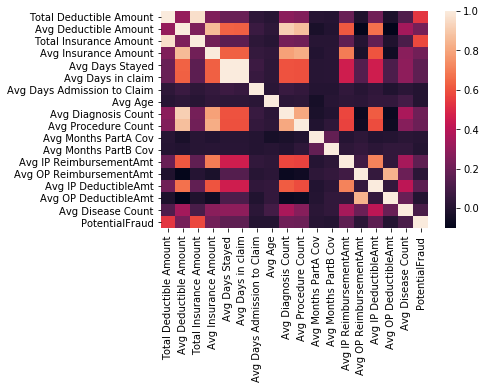

In [16]:
corr = train_data.corr()
#plot correlation plot before diving in
sn.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

### Compare different oversampling techniques

Ref :https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/combine/plot_comparison_combine.html#sphx-glr-auto-examples-combine-plot-comparison-combine-py

As seen in plot below we will use SMOTE later below for tackling imblance data

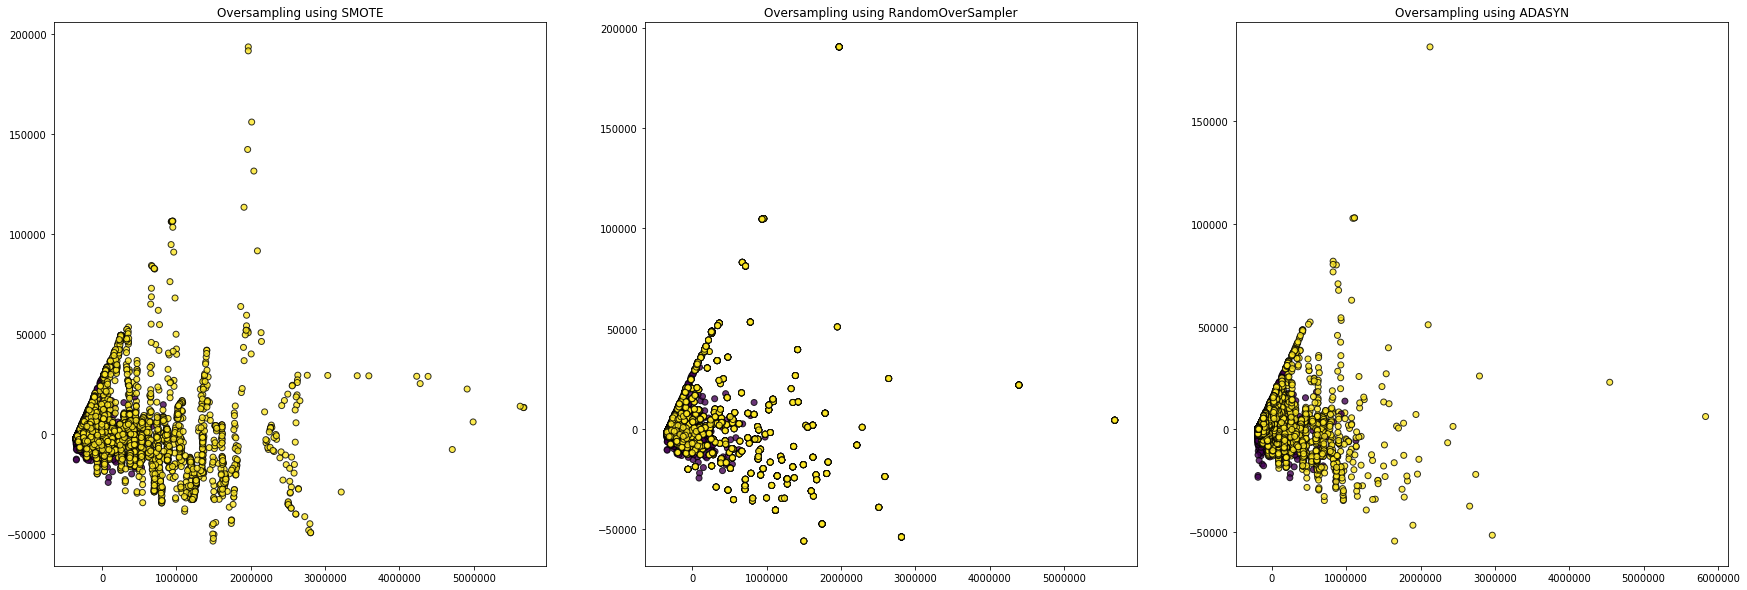

In [17]:
def plot_resampling(X, y, sampling, ax):
    X_rs, y_rs = sampling.fit_resample(X, y)
    #do PCA on features to plot and visualize
    pca = PCA(n_components=2)
    X_rs = pca.fit_transform(X_rs)
    ax.scatter(X_rs[:, 0], X_rs[:, 1], c=y_rs, alpha=0.8, edgecolor='k')
    return Counter(y_rs)

X = train_data.loc[:, train_data.columns != 'PotentialFraud']
X = train_data.loc[:, train_data.columns != 'Provider']
y = train_data.PotentialFraud

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(30, 10))
ax_arr = (ax1, ax2, ax3)
for ax, sampler in zip(ax_arr, (
        SMOTE(random_state=12345),
        RandomOverSampler(random_state=12345),
        ADASYN(random_state=12345))):
    pipeline = make_pipeline(sampler, LinearSVC())
    pipeline.fit(X, y)
    plot_resampling(X, y, sampler, ax)
    ax.set_title('Oversampling using {}'.format(
        sampler.__class__.__name__))
plt.show()

In [18]:
train_data.columns

Index(['Total Deductible Amount', 'Avg Deductible Amount',
       'Total Insurance Amount', 'Avg Insurance Amount', 'Avg Days Stayed',
       'Avg Days in claim', 'Avg Days Admission to Claim', 'Avg Age',
       'Avg Diagnosis Count', 'Avg Procedure Count', 'Avg Months PartA Cov',
       'Avg Months PartB Cov', 'Avg IP ReimbursementAmt',
       'Avg OP ReimbursementAmt', 'Avg IP DeductibleAmt',
       'Avg OP DeductibleAmt', 'Avg Disease Count', 'Provider',
       'PotentialFraud'],
      dtype='object')

## Applying various Models for solving the Binary CLassification Problem in hand (Fraud Detection)

### Splitting the data into Train and test in 80:20 Ratio

In [19]:
X = train_data[['Total Deductible Amount', 'Avg Deductible Amount',
       'Total Insurance Amount', 'Avg Insurance Amount', 'Avg Days Stayed',
       'Avg Days in claim', 'Avg Days Admission to Claim', 'Avg Age',
       'Avg Diagnosis Count', 'Avg Procedure Count', 'Avg Months PartA Cov',
       'Avg Months PartB Cov', 'Avg IP ReimbursementAmt',
       'Avg OP ReimbursementAmt', 'Avg IP DeductibleAmt',
       'Avg OP DeductibleAmt', 'Avg Disease Count']]
Y = train_data.PotentialFraud
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.20, random_state=12345)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_train.value_counts())
print(Y_test.value_counts())

(3198, 17)
(800, 17)
(3198,)
(800,)
0    2881
1     317
Name: PotentialFraud, dtype: int64
0    734
1     66
Name: PotentialFraud, dtype: int64


### Standardizing the data 

In [20]:
X_train_std = StandardScaler(with_mean=False)
# here it will learn mu and sigma
X_train_std.fit(X_train)

## Training Set
X_train = X_train_std.transform(X_train)
## Testing set
X_test = X_train_std.transform(X_test)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3198, 17)
(800, 17)
(3198,)
(800,)


<h2> <font color = blue> Without Oversampling (Imbalanced Classes)

### Function to Train data and do crossvalidation and selection of best hyperparameter

In [21]:
def call_model(model,final_xtr, ytr):

    if model == 1: #Logistic Regression
        penalty = 'l2'
        grid_values = {'penalty': [penalty], 'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5]}   
        clf = GridSearchCV(LogisticRegression(), param_grid= grid_values, cv=5,return_train_score=True,
                           scoring= 'roc_auc')
        clf.fit(final_xtr, ytr)
        c = clf.best_params_['C']
        print('Best value of C(1/lambda) = ',c)
   
    elif model == 2: #Random Forest
        parameters = {
        'n_estimators'      : [50,100,200,300,500]
        }

        clf = GridSearchCV(RandomForestClassifier(), parameters, cv=5,return_train_score=True,
                           scoring= 'roc_auc')

        clf.fit(final_xtr, ytr)
        c = clf.best_params_['n_estimators']
        print('Best value of n_estimators = ',c)

    elif model == 3:    ## SVM
        gammas = [0.001, 0.01, 0.1, 1]
        parameters = {'gamma' : gammas}

        clf = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5,return_train_score=True,
                           scoring= 'roc_auc')

        clf.fit(final_xtr, ytr)
        c = clf.best_params_['gamma']
        print('Best value of gamma = ',c)
        
    elif model == 4: #KNN
        n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15, 17]
        parameters = {'n_neighbors' : n_neighbors}

        clf = GridSearchCV(KNeighborsClassifier(), parameters, cv=5,return_train_score=True,
                           scoring= 'roc_auc')
        clf.fit(final_xtr, ytr)
        c = clf.best_params_['n_neighbors']
        print('Best value of n_neighbors = ',c)
        

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    cv_scores_tr = clf.cv_results_['mean_train_score']
    cv_scores_cv = clf.cv_results_['mean_test_score']
    return cv_scores_tr, cv_scores_cv, c    

### Function to test the model

In [22]:
def test_acc(model,optimal_c,final_xtr, ytr,final_xtest,ytest):
    
    if model == 1:
        penalty = 'l2'
        ## Logistic Regression
        clf_optimal = LogisticRegression(C=optimal_c,penalty=penalty)
    elif model == 2:
        ## Random Forest
        clf_optimal = RandomForestClassifier(n_estimators=optimal_c)
    elif model == 3:
        ## SVM
        clf_optimal = SVC(C=optimal_c, kernel='rbf',probability=True)
    elif model == 4:
        ## KNN
        clf_optimal = KNeighborsClassifier(n_neighbors=optimal_c)
        
    ## IDentifying the True Positive, True Negative, False Positive and False NEgative    
    clf_optimal.fit(final_xtr, ytr)
    pred_prob_ts = clf_optimal.predict_proba(final_xtest).T[1]
    fpr_ts, tpr_ts, threshold = roc_curve(ytest, pred_prob_ts)     
    pred_prob_tr = clf_optimal.predict_proba(final_xtr).T[1]
    fpr_tr, tpr_tr, threshold = roc_curve(ytr, pred_prob_tr)     
    pred = clf_optimal.predict(final_xtest)    

    return clf_optimal,pred, fpr_ts, tpr_ts, fpr_tr, tpr_tr

### Function to plot AUC curve for Training and Validation data

In [23]:
def train_val_auc(cv_scores_tr, cv_scores_cv,hg):

    tt = np.round(np.log(hg),2)
    tt

    auclist = np.arange(0.7,1.1,0.1)
    fig = plt.figure(figsize= (28,18))
    plt.grid(b=True, which='major', color='grey', linestyle='-')

    plt.plot(tt, cv_scores_cv, 'b', label='Validation AUC')
    plt.plot(tt, cv_scores_tr, 'r', label='Training AUC')
    plt.xlabel('Alpha')
    plt.ylabel('Area under ROC Curve')
    plt.xticks(tt,hg)
    plt.yticks(auclist)

    plt.legend(loc="lower right",prop={'size': 24})
    plt.show()


### Function to plot ROC-AUC Curve for Train and Validation data

In [24]:
def roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr):

    import matplotlib.pyplot as plt

    roc_auc_ts = auc(fpr_ts, tpr_ts)
    roc_auc_tr = auc(fpr_tr, tpr_tr)

    fig = plt.figure(figsize= (18,8))
    plt.grid(b=True, which='major', color='grey', linestyle='-')
    plt.plot(fpr_ts, tpr_ts, color='darkorange', lw=1, label='Test ROC curve (area = %0.3f)' % roc_auc_ts)
    plt.plot(fpr_tr, tpr_tr, color='red', lw=1, label='Training ROC curve (area = %0.3f)' % roc_auc_tr)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right",prop={'size': 22})
    plt.show()

### Function to plot Confusion Matrix

In [25]:
def conf_mat(pred,ytest):
    
    
    labels = ['Not Fraud','Fraud']

    ## Accuracy
    cm_lr = confusion_matrix(ytest,pred)
    ## Precision
    rc =(((cm_lr.T)/(cm_lr.sum(axis=1))).T)
    ## Recall
    pr =(cm_lr/cm_lr.sum(axis=0))
    cm = cm_lr
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    
    sk_recall = recall_score(ytest,pred, average='macro')
    sk_precision = precision_score(ytest,pred ,average='macro')
    
    #label size setting
    sn.set(font_scale=1.5)
    
    print("-"*20, "Confusion matrix", "-"*20)
    #plotting using heatmap for total count
    cm_lrdf = pd.DataFrame(cm_lr, range(2),range(2))
    plt.figure(figsize=(5,5))
    sn.heatmap(cm_lrdf, annot=True, cmap="YlGn", fmt=".3f", xticklabels=labels, yticklabels=labels)
   
    
    plt.xlabel('Original Class')
    plt.ylabel('Predicted Class')
    plt.autoscale()
    plt.show()
    
    print("-"*20, "Precision matrix  (Col Sum=1)", "-"*20)
    #plotting using heatmap for Precision
    cm_prdf = pd.DataFrame(pr, range(2),range(2))
    plt.figure(figsize=(5,5))
    sn.heatmap(cm_prdf, annot=True, cmap="YlGn", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Original Class')
    plt.ylabel('Predicted Class')
    plt.autoscale()
    plt.show()
    
    print("-"*20, "Recall matrix  (Row Sum=1) -", "-"*20)
    #plotting using heatmap for total count
    cm_rcdf = pd.DataFrame(rc, range(2),range(2))
    plt.figure(figsize=(5,5))
    sn.heatmap(cm_rcdf, annot=True, cmap="YlGn", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Original Class')
    plt.ylabel('Predicted Class')
    plt.autoscale()
    plt.show()
    
    cm_prdf = np.nan_to_num(cm_prdf)
    cm_rcdf = np.nan_to_num(cm_rcdf)   
    pr = np.nan_to_num(pr)
    rc = np.nan_to_num(rc)
    
    
    confmat_summary = pd.DataFrame({
'Not Fraud': [cm_prdf[0][0],cm_rcdf[0][0], (2*cm_prdf[0][0]*cm_rcdf[0][0])/(cm_prdf[0][0] + cm_rcdf[0][0])],
'Fraud': [cm_prdf[1][1],cm_rcdf[1][1],(2*cm_prdf[1][1]*cm_rcdf[1][1])/(cm_prdf[1][1] + cm_rcdf[1][1])]},
index=['Precision','Recall','F1-Score'])
    
    #print(classification_report(ytest, pred, labels=[0,1]))
    
    print(confmat_summary)



### Function to plot Precision-Recall Curve

In [26]:
def pr_recall_curve(Y_test, pred):
    precision, recall, thresholds_pr = precision_recall_curve(Y_test, pred)
    AUC_PRcurve= auc(recall, precision)
    plt.figure(1)
    #plot PR curve
    plt.plot(precision, recall, label = "AUC = {:0.2f}".format(AUC_PRcurve))
    plt.xlabel('Precision', fontsize = 14)
    plt.ylabel('Recall', fontsize = 14)
    plt.title('Precision-Recall Curve', fontsize = 18)
    plt.legend(loc='best')
    plt.show()

<h2> <font color = blue> 1. Logistic Regression

In [27]:
#Call the function to do cross validation (GridSearchCV) and return the scores correponding to different lamdba values
cv_scores_tr, cv_scores_cv, optimal_c= call_model(1,X_train, Y_train)

Best value of C(1/lambda) =  0.1
0.882 (+/-0.032) for {'C': 1e-05, 'penalty': 'l2'}
0.885 (+/-0.032) for {'C': 0.0001, 'penalty': 'l2'}
0.900 (+/-0.030) for {'C': 0.001, 'penalty': 'l2'}
0.921 (+/-0.026) for {'C': 0.01, 'penalty': 'l2'}
0.929 (+/-0.025) for {'C': 0.1, 'penalty': 'l2'}
0.927 (+/-0.026) for {'C': 1.0, 'penalty': 'l2'}
0.925 (+/-0.028) for {'C': 10.0, 'penalty': 'l2'}
0.925 (+/-0.029) for {'C': 100.0, 'penalty': 'l2'}
0.925 (+/-0.031) for {'C': 1000.0, 'penalty': 'l2'}
0.924 (+/-0.031) for {'C': 10000.0, 'penalty': 'l2'}
0.926 (+/-0.029) for {'C': 100000.0, 'penalty': 'l2'}


<h3> 'Training - Validation' AUC </h2>

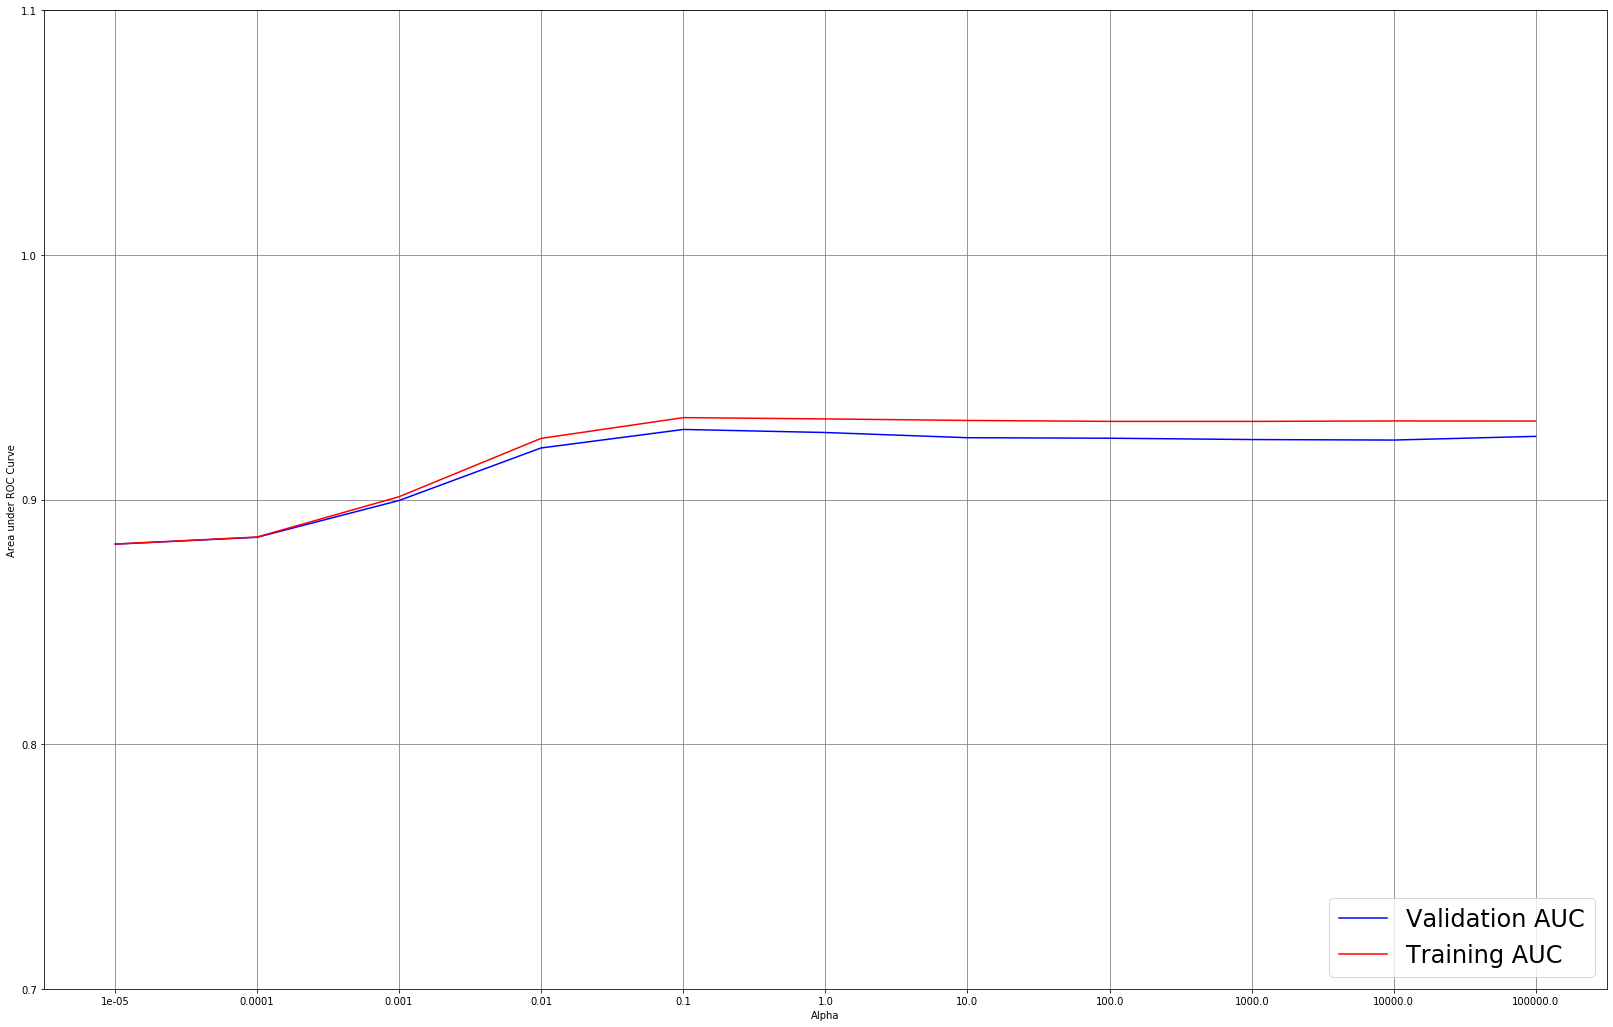

In [28]:
lambdalistorg = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5]
train_val_auc(cv_scores_tr, cv_scores_cv,lambdalistorg)

In [29]:
# Calculating the Test accuracy by calling the function test_acc
lrmodel,pred, fpr_ts, tpr_ts,fpr_tr, tpr_tr = test_acc(1,optimal_c,X_train,Y_train,X_test,Y_test)

<h3> ROC - AUC Curve </h3>

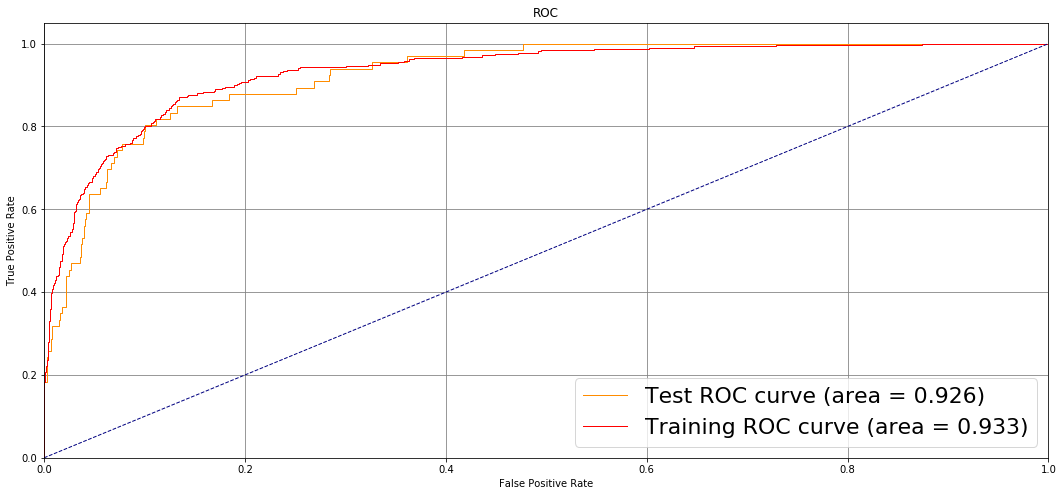

In [30]:
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


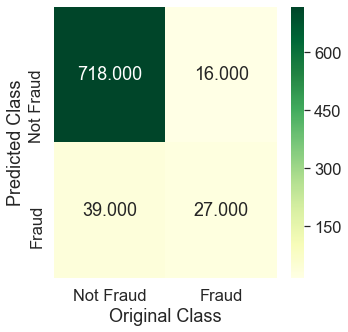

-------------------- Precision matrix  (Col Sum=1) --------------------


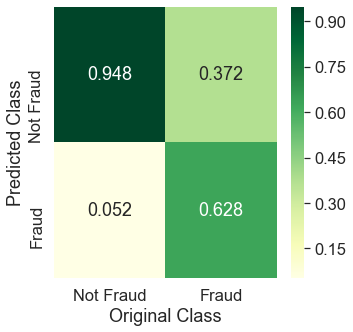

-------------------- Recall matrix  (Row Sum=1) - --------------------


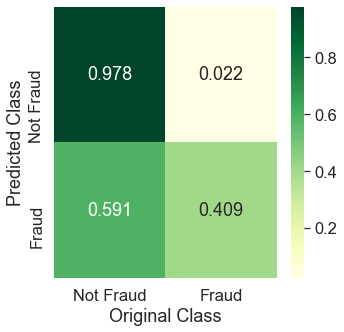

           Not Fraud     Fraud
Precision   0.948481  0.627907
Recall      0.978202  0.409091
F1-Score    0.963112  0.495413


In [31]:
conf_mat(pred,Y_test)

### Precision-Recall Curve

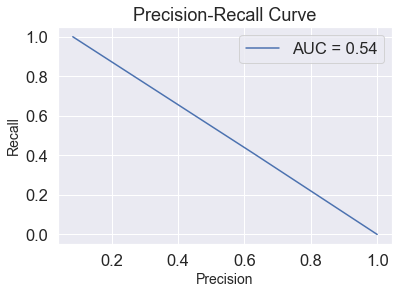

In [32]:
pr_recall_curve(Y_test, pred)

<h2> <font color = blue> 2. Random Forest
    

In [33]:
#Call the function to do cross validation (GridSearchCV) and return the scores correponding to different lamdba values
cv_scores_tr, cv_scores_cv, optimal_t= call_model(2,X_train, Y_train)

Best value of n_estimators =  200
0.926 (+/-0.022) for {'n_estimators': 50}
0.926 (+/-0.029) for {'n_estimators': 100}
0.932 (+/-0.022) for {'n_estimators': 200}
0.930 (+/-0.023) for {'n_estimators': 300}
0.932 (+/-0.026) for {'n_estimators': 500}


<h3> 'Training - Validation' AUC </h2>

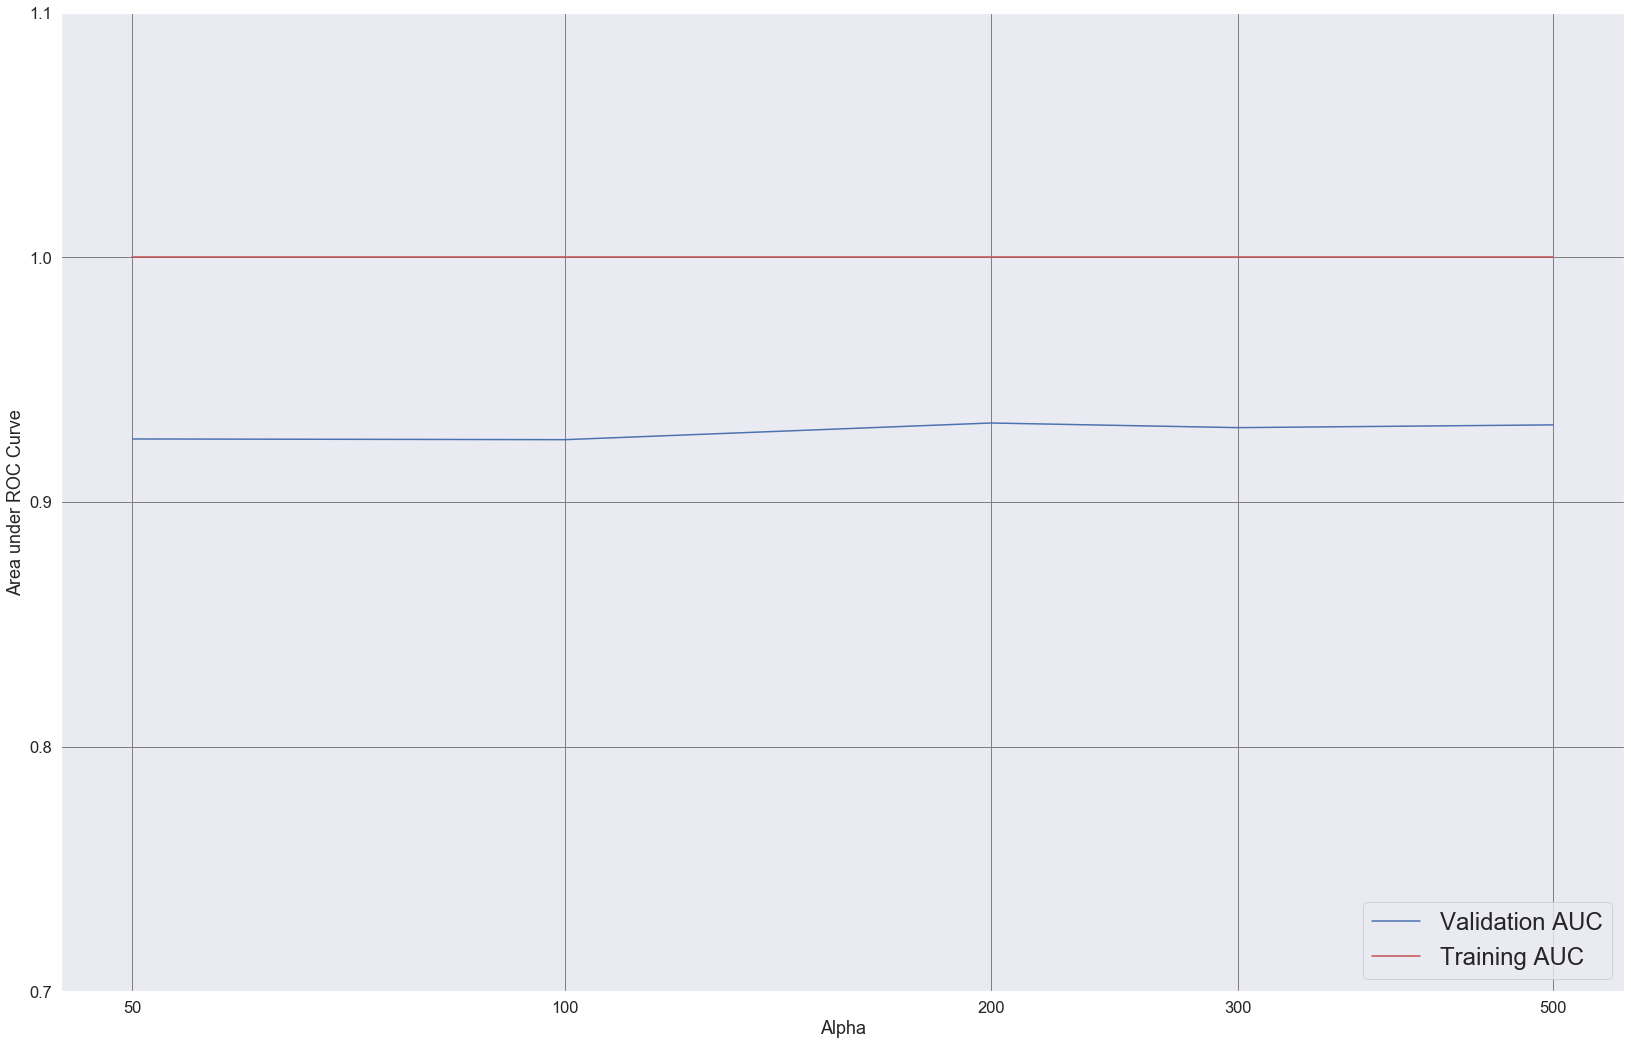

In [34]:
lambdalistorg = [50,100,200,300,500]
train_val_auc(cv_scores_tr, cv_scores_cv,lambdalistorg)

In [35]:
# Calculating the Test accuracy by calling the function test_acc
lrmodel,pred, fpr_ts, tpr_ts,fpr_tr, tpr_tr = test_acc(2,optimal_t,X_train,Y_train,X_test,Y_test)

<h3> ROC - AUC Curve </h3>

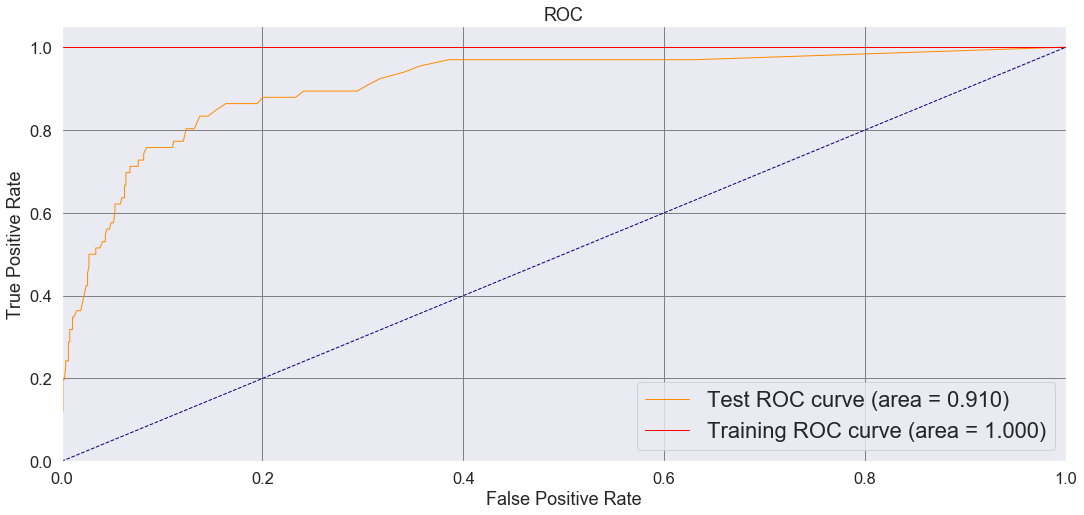

In [36]:
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


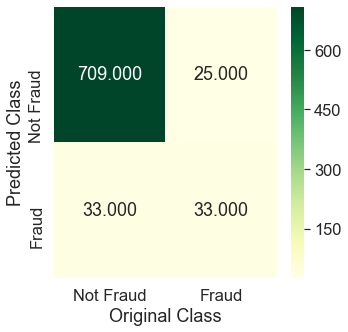

-------------------- Precision matrix  (Col Sum=1) --------------------


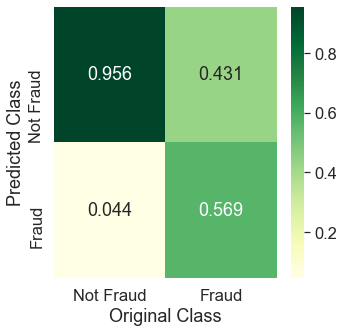

-------------------- Recall matrix  (Row Sum=1) - --------------------


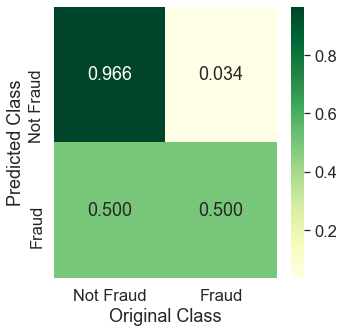

           Not Fraud     Fraud
Precision   0.955526  0.568966
Recall      0.965940  0.500000
F1-Score    0.960705  0.532258


In [37]:
conf_mat(pred,Y_test)

### Precision-Recall Curve

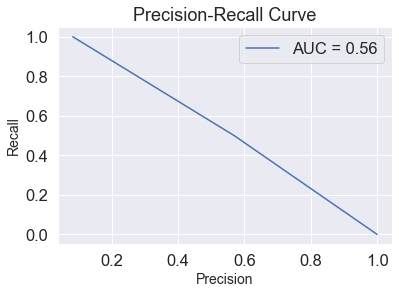

In [38]:
pr_recall_curve(Y_test, pred)

<h2> <font color = blue> 3. SVM

In [39]:
#Call the function to do cross validation (GridSearchCV) and return the scores correponding to different lamdba values
cv_scores_tr, cv_scores_cv, optimal_c= call_model(3,X_train, Y_train)

Best value of gamma =  0.001
0.935 (+/-0.024) for {'gamma': 0.001}
0.924 (+/-0.020) for {'gamma': 0.01}
0.858 (+/-0.040) for {'gamma': 0.1}
0.842 (+/-0.045) for {'gamma': 1}


<h3> 'Training - Validation' AUC </h2>

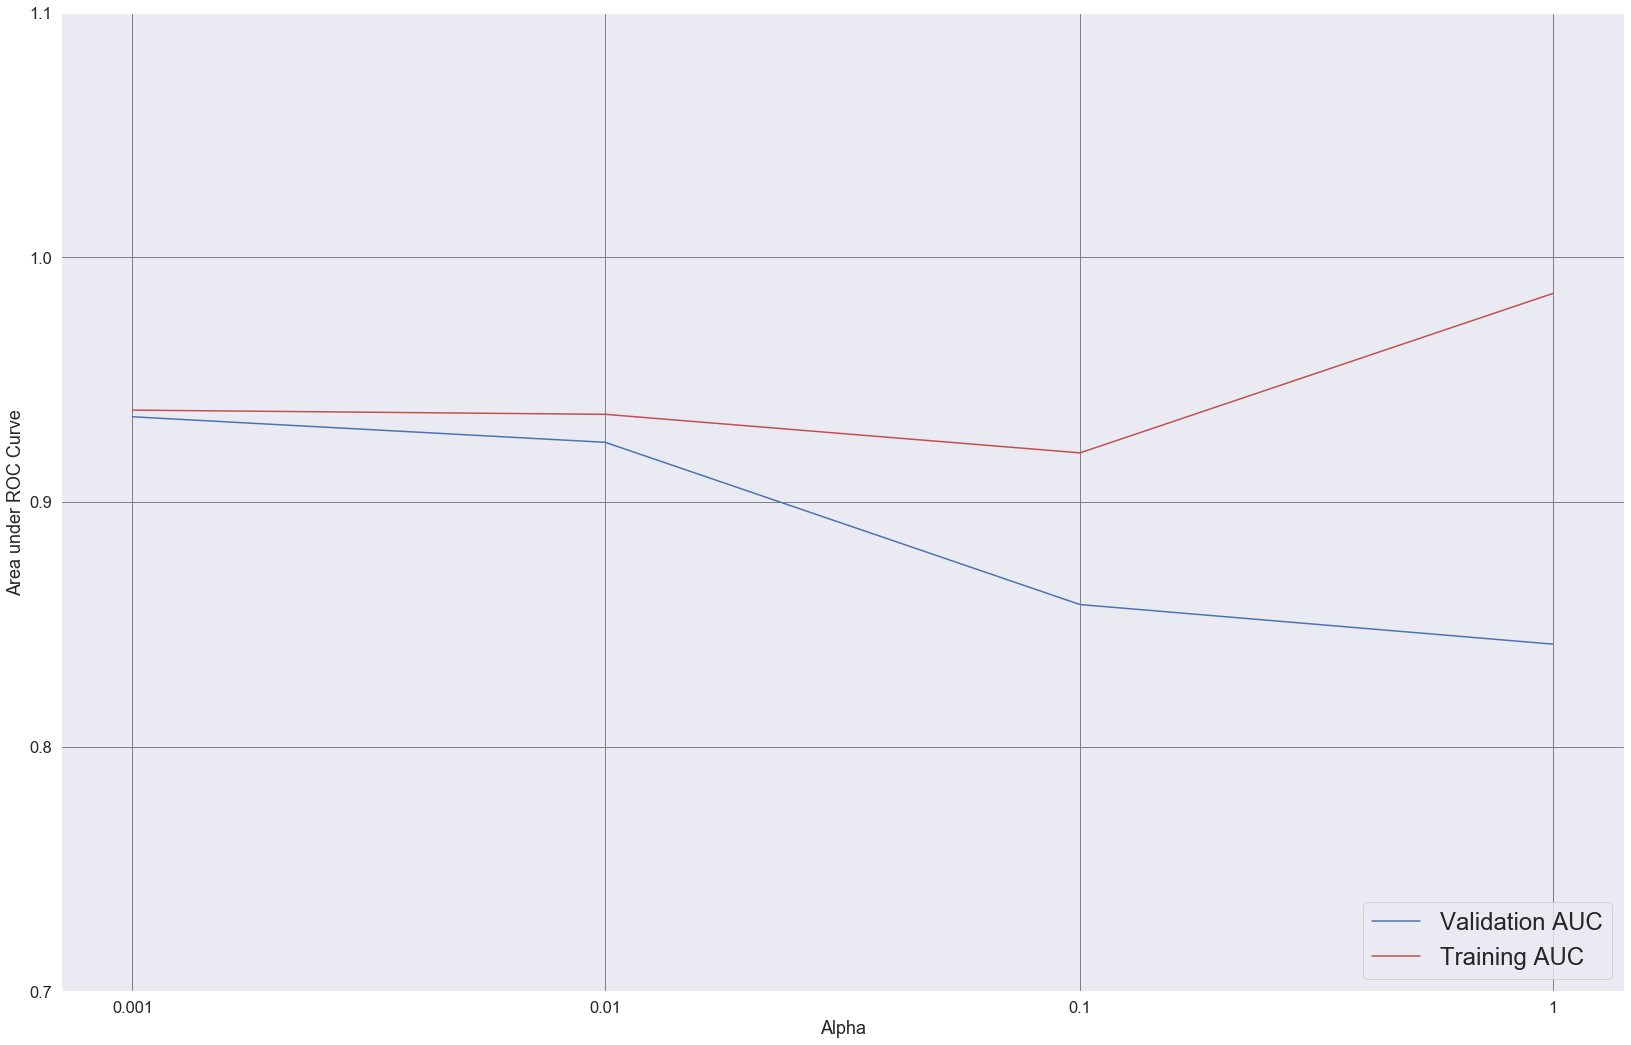

In [40]:
lambdalistorg = [0.001, 0.01, 0.1, 1]
train_val_auc(cv_scores_tr, cv_scores_cv,lambdalistorg)

In [41]:
# Calculating the Test accuracy by calling the function test_acc
lrmodel,pred, fpr_ts, tpr_ts,fpr_tr, tpr_tr = test_acc(3,optimal_c,X_train,Y_train,X_test,Y_test)

<h3> ROC - AUC Curve </h3>

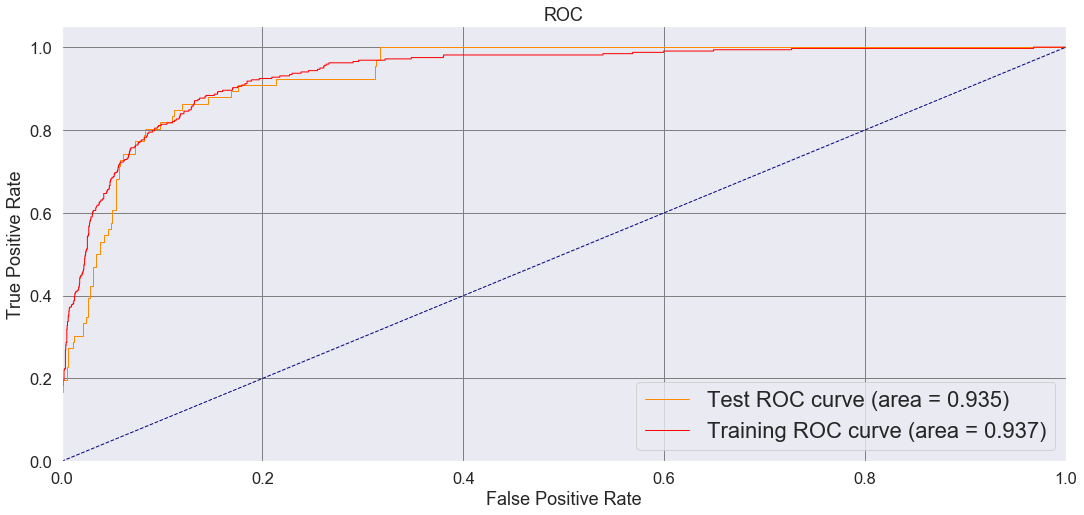

In [42]:
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


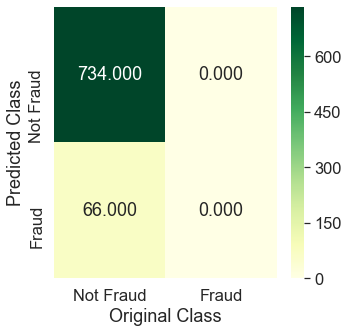

-------------------- Precision matrix  (Col Sum=1) --------------------


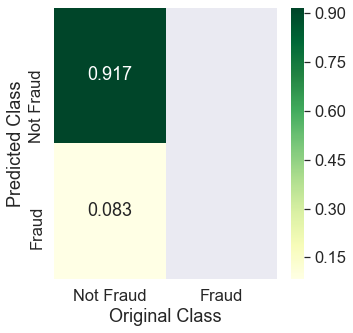

-------------------- Recall matrix  (Row Sum=1) - --------------------


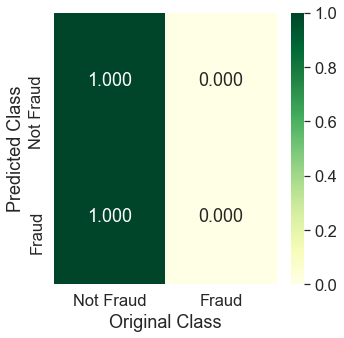

           Not Fraud  Fraud
Precision   0.917500    0.0
Recall      1.000000    0.0
F1-Score    0.956975    NaN


In [43]:
conf_mat(pred,Y_test)

### Precision-Recall Curve

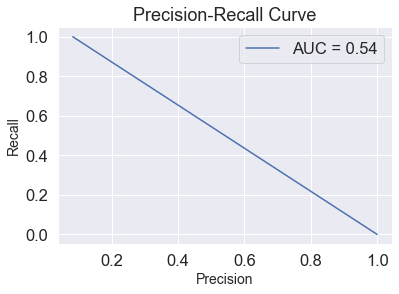

In [44]:
pr_recall_curve(Y_test, pred)

<h2> <font color = blue> 4. KNN

In [45]:
#Call the function to do cross validation (GridSearchCV) and return the scores correponding to different lamdba values
cv_scores_tr, cv_scores_cv, optimal_c= call_model(4,X_train, Y_train)

Best value of n_neighbors =  17
0.727 (+/-0.065) for {'n_neighbors': 1}
0.832 (+/-0.026) for {'n_neighbors': 3}
0.867 (+/-0.020) for {'n_neighbors': 5}
0.885 (+/-0.030) for {'n_neighbors': 7}
0.899 (+/-0.029) for {'n_neighbors': 9}
0.906 (+/-0.020) for {'n_neighbors': 11}
0.911 (+/-0.029) for {'n_neighbors': 13}
0.911 (+/-0.031) for {'n_neighbors': 15}
0.912 (+/-0.037) for {'n_neighbors': 17}


<h3> 'Training - Validation' AUC </h2>

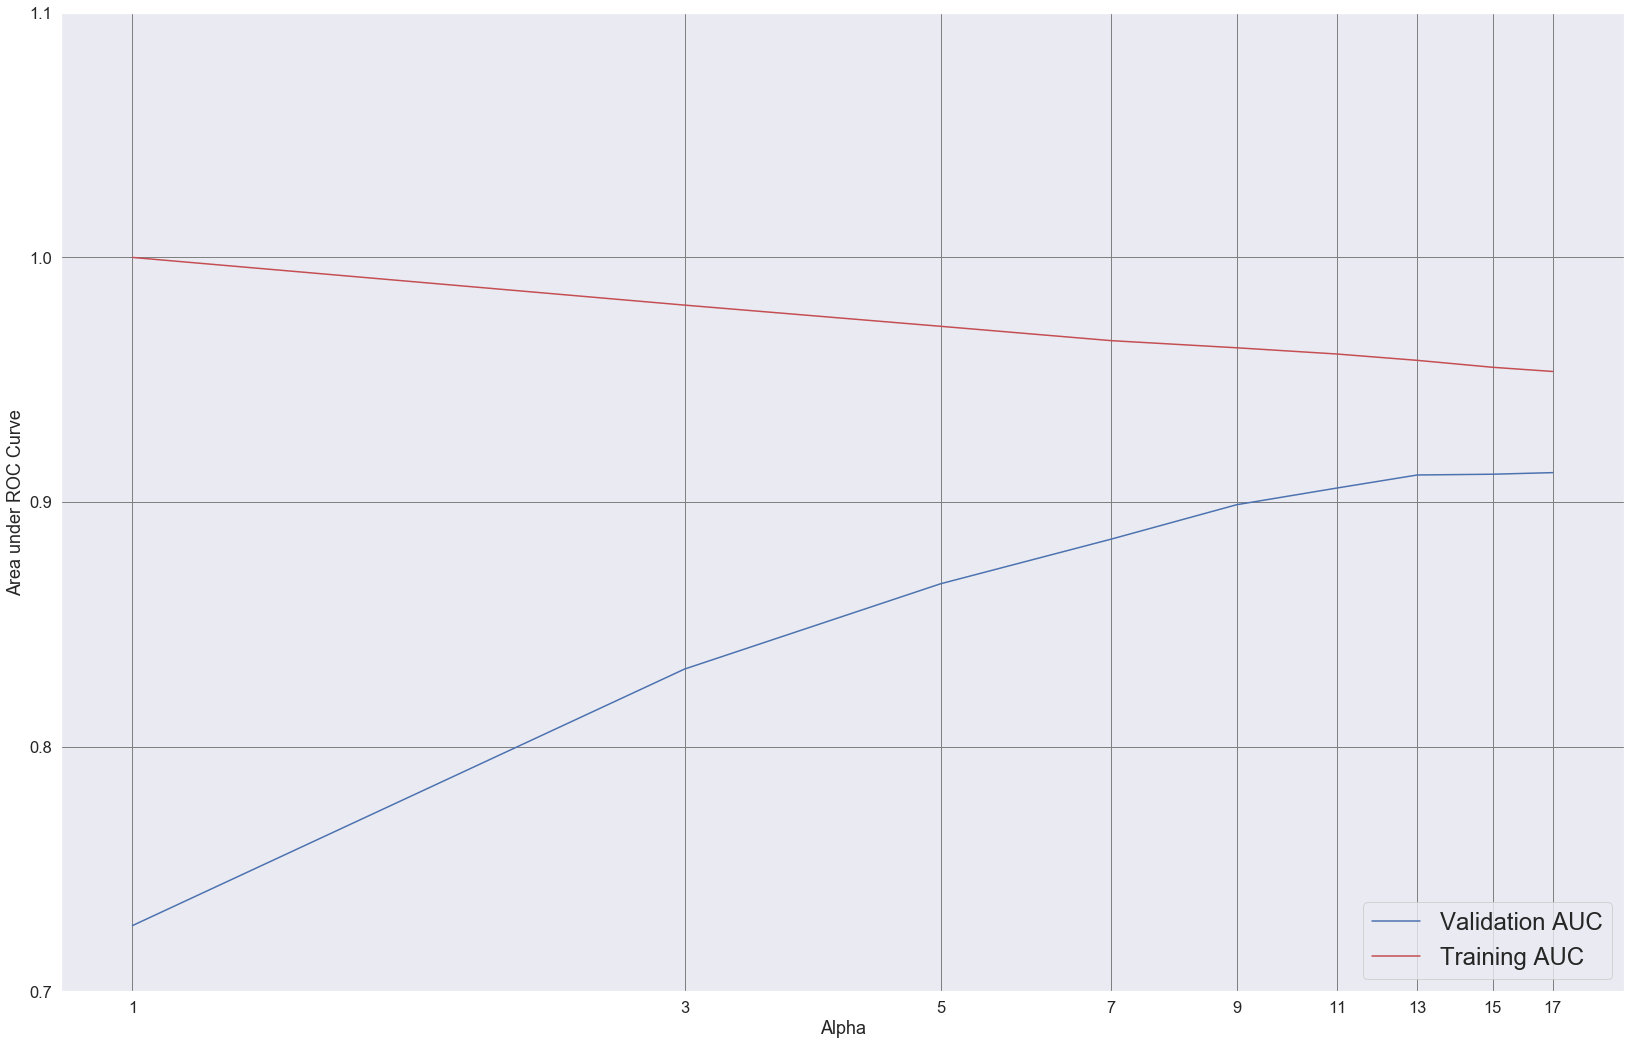

In [46]:
lambdalistorg = [1, 3, 5, 7, 9, 11, 13, 15, 17]
train_val_auc(cv_scores_tr, cv_scores_cv,lambdalistorg)

In [47]:
# Calculating the Test accuracy by calling the function test_acc
lrmodel,pred, fpr_ts, tpr_ts,fpr_tr, tpr_tr = test_acc(4,optimal_c,X_train,Y_train,X_test,Y_test)

<h3> ROC - AUC Curve </h3>

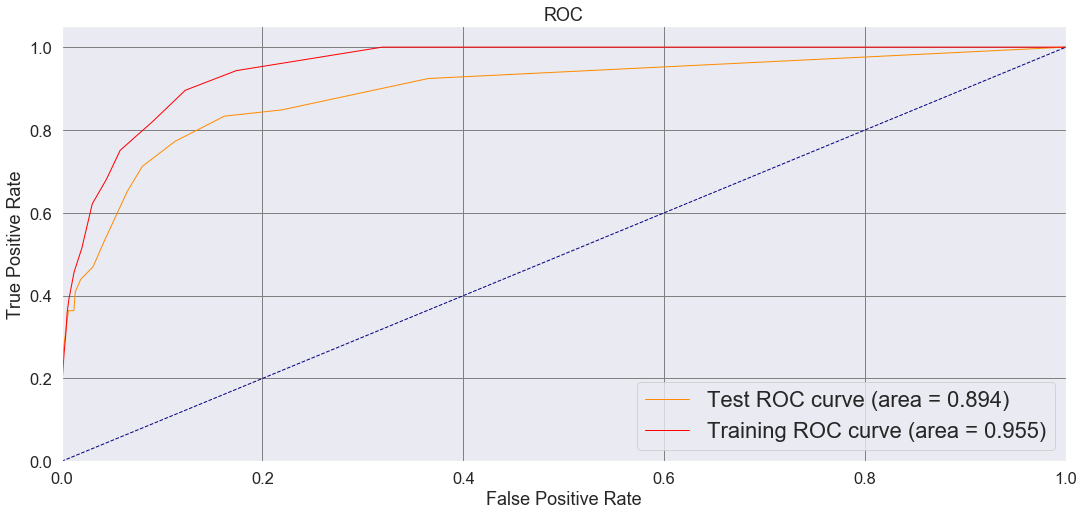

In [48]:
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


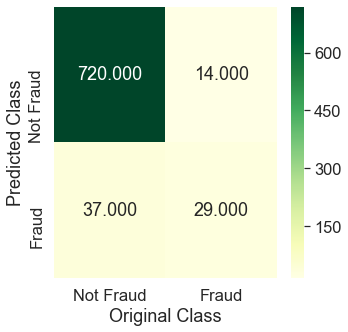

-------------------- Precision matrix  (Col Sum=1) --------------------


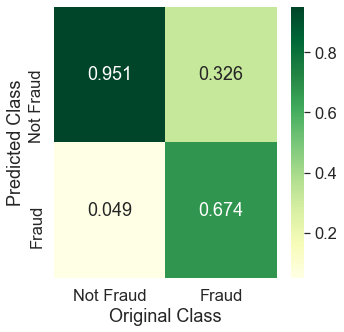

-------------------- Recall matrix  (Row Sum=1) - --------------------


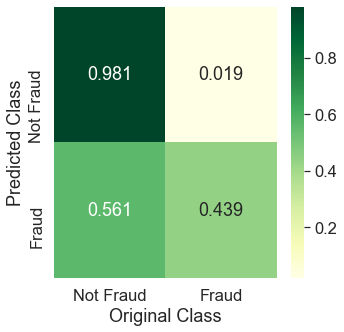

           Not Fraud     Fraud
Precision   0.951123  0.674419
Recall      0.980926  0.439394
F1-Score    0.965795  0.532110


In [49]:
conf_mat(pred,Y_test)

### Precision-Recall Curve

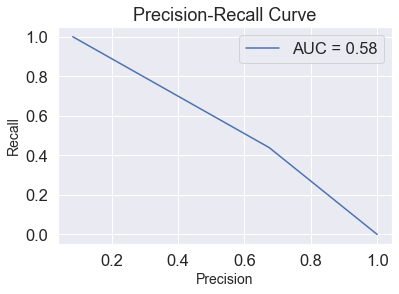

In [50]:
pr_recall_curve(Y_test, pred)

<h2> <font color = blue> 5. Neural Network

In [51]:
model = Sequential()
model.add(Dense(64, input_shape = (17,), activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(1, activation = 'sigmoid'))
sgd = adam(lr = 0.001)
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1152      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [52]:
model.fit(X_train, Y_train, batch_size = 700, epochs = 10, verbose = 1)

Epoch 1/10
3198/3198 [==============================] - 3s 962us/step - loss: 0.7907 - accuracy: 0.5175
Epoch 2/10
3198/3198 [==============================] - 0s 40us/step - loss: 0.7041 - accuracy: 0.6094
Epoch 3/10
3198/3198 [==============================] - 0s 41us/step - loss: 0.6641 - accuracy: 0.6739
Epoch 4/10
3198/3198 [==============================] - 0s 47us/step - loss: 0.6322 - accuracy: 0.7142
Epoch 5/10
3198/3198 [==============================] - 0s 43us/step - loss: 0.5912 - accuracy: 0.7536
Epoch 6/10
3198/3198 [==============================] - 0s 41us/step - loss: 0.5717 - accuracy: 0.7649
Epoch 7/10
3198/3198 [==============================] - 0s 41us/step - loss: 0.5503 - accuracy: 0.7949
Epoch 8/10
3198/3198 [==============================] - 0s 41us/step - loss: 0.5239 - accuracy: 0.8202
Epoch 9/10
3198/3198 [==============================] - 0s 41us/step - loss: 0.4935 - accuracy: 0.8452
Epoch 10/10
3198/3198 [==============================] - 0s 41us/step - 

In [53]:
results = model.evaluate(X_test, Y_test)


800/800 [==============================] - 1s 729us/step


In [54]:
print(model.metrics_names)
print(results)    

['loss', 'accuracy']
[2.1282350635528564, 0.08375000208616257]


<h3> ROC - AUC Curve </h3>

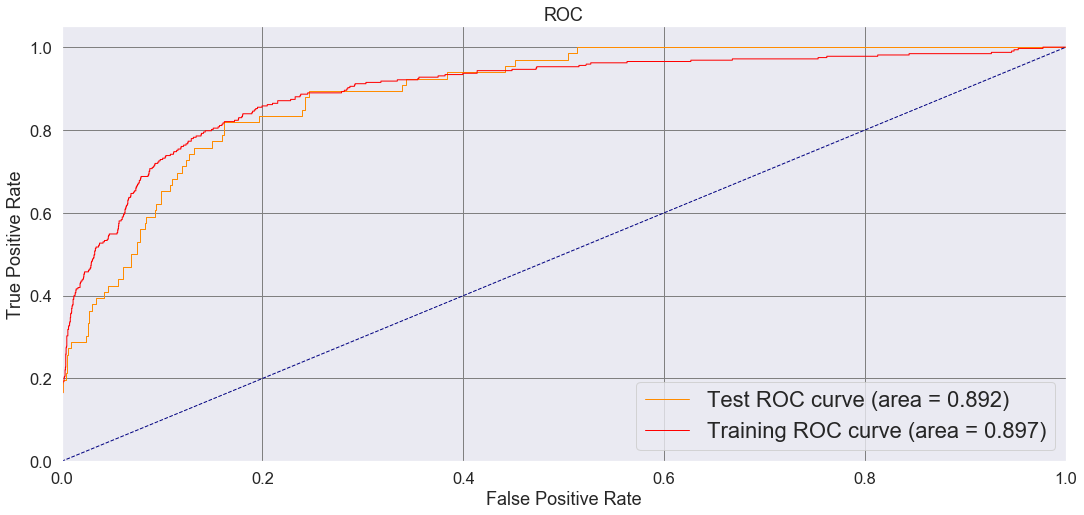

In [55]:
# predict the response Probabilities for Test data
pred_prob_ts = model.predict_proba(X_test)
# AUC for Test data
fpr_ts, tpr_ts, threshold = roc_curve(Y_test, pred_prob_ts)     

# predict the response Probabilities for Training data
pred_prob_tr = model.predict_proba(X_train)
# AUC for Training data
fpr_tr, tpr_tr, threshold = roc_curve(Y_train, pred_prob_tr)  
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


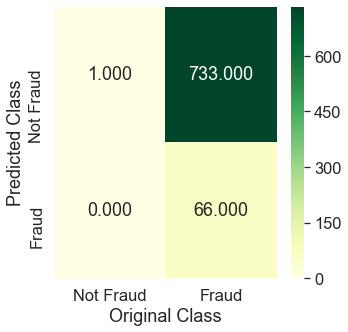

-------------------- Precision matrix  (Col Sum=1) --------------------


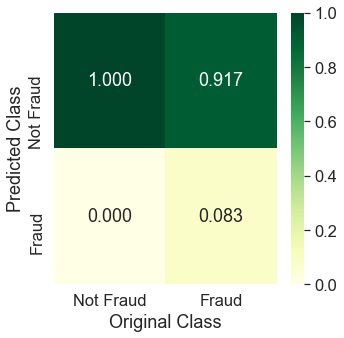

-------------------- Recall matrix  (Row Sum=1) - --------------------


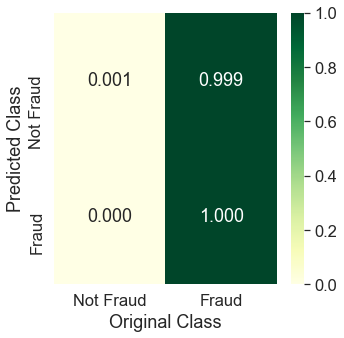

           Not Fraud     Fraud
Precision   1.000000  0.082603
Recall      0.001362  1.000000
F1-Score    0.002721  0.152601


In [56]:
Y_pred_cls = model.predict_classes(X_test, batch_size=200, verbose=0)
conf_mat(Y_pred_cls,Y_test)

### Precision-Recall Curve

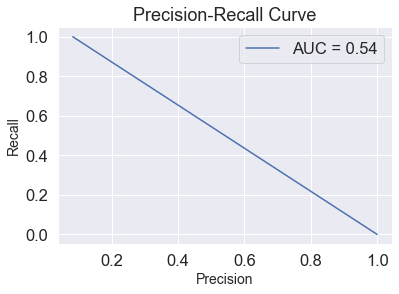

In [57]:
precision, recall, thresholds_pr = precision_recall_curve(Y_test, Y_pred_cls)
AUC_PRcurve= auc(recall, precision)
plt.figure(1)
#plot PR curve
plt.plot(precision, recall, label = "AUC = {:0.2f}".format(AUC_PRcurve))
plt.xlabel('Precision', fontsize = 14)
plt.ylabel('Recall', fontsize = 14)
plt.title('Precision-Recall Curve', fontsize = 18)
plt.legend(loc='best')
plt.show()

<h2> <font color = maroon> With Oversampling (Balanced Classes)

## <font color = blue> **Oversampling** </font> for correcting class imbalance

In [58]:
X = train_data[['Total Deductible Amount', 'Avg Deductible Amount',
       'Total Insurance Amount', 'Avg Insurance Amount', 'Avg Days Stayed',
       'Avg Days in claim', 'Avg Days Admission to Claim', 'Avg Age',
       'Avg Diagnosis Count', 'Avg Procedure Count', 'Avg Months PartA Cov',
       'Avg Months PartB Cov', 'Avg IP ReimbursementAmt',
       'Avg OP ReimbursementAmt', 'Avg IP DeductibleAmt',
       'Avg OP DeductibleAmt', 'Avg Disease Count']]
Y = train_data.PotentialFraud
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.20, random_state=12345)
X_train_std = StandardScaler(with_mean=False)
# here it will learn mu and sigma
X_train_std.fit(X_train)

## Training Set
X_train = X_train_std.transform(X_train)
## Testing set
X_test = X_train_std.transform(X_test)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3198, 17)
(800, 17)
(3198,)
(800,)


### Applying SMOTE to oversample the data

In [59]:
from imblearn.over_sampling import SMOTE
ros = SMOTE(random_state=42)
X_train, Y_train = ros.fit_resample(X_train, Y_train)
print(pd.Series(Y_train).value_counts())

1    2881
0    2881
Name: PotentialFraud, dtype: int64


<h2> <font color = blue> 1. Logistic Regression

In [60]:
#Call the function to do cross validation (GridSearchCV) and return the scores correponding to different lamdba values
cv_scores_tr, cv_scores_cv, optimal_c= call_model(1,X_train, Y_train)

Best value of C(1/lambda) =  1.0
0.891 (+/-0.012) for {'C': 1e-05, 'penalty': 'l2'}
0.897 (+/-0.012) for {'C': 0.0001, 'penalty': 'l2'}
0.922 (+/-0.014) for {'C': 0.001, 'penalty': 'l2'}
0.945 (+/-0.014) for {'C': 0.01, 'penalty': 'l2'}
0.950 (+/-0.013) for {'C': 0.1, 'penalty': 'l2'}
0.951 (+/-0.014) for {'C': 1.0, 'penalty': 'l2'}
0.950 (+/-0.015) for {'C': 10.0, 'penalty': 'l2'}
0.950 (+/-0.015) for {'C': 100.0, 'penalty': 'l2'}
0.950 (+/-0.014) for {'C': 1000.0, 'penalty': 'l2'}
0.950 (+/-0.014) for {'C': 10000.0, 'penalty': 'l2'}
0.950 (+/-0.015) for {'C': 100000.0, 'penalty': 'l2'}


<h3> 'Training - Validation' AUC </h2>

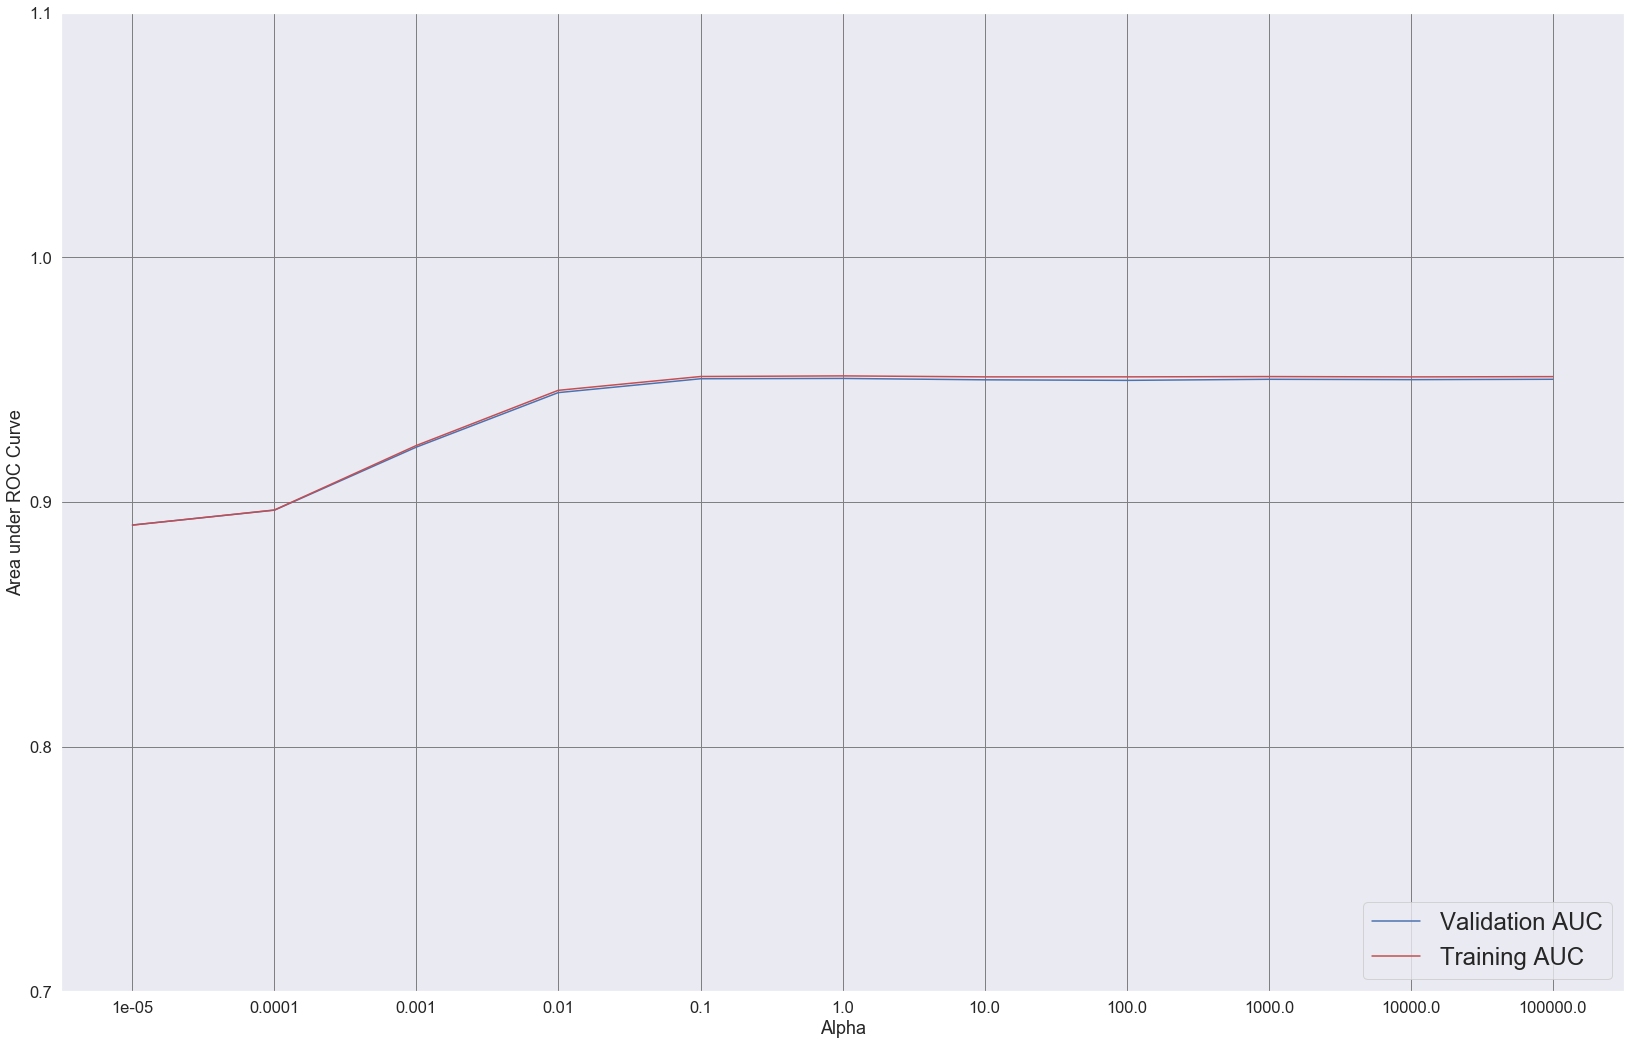

In [61]:
lambdalistorg = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5]
train_val_auc(cv_scores_tr, cv_scores_cv,lambdalistorg)

In [62]:
# Calculating the Test accuracy by calling the function test_acc
lrmodel,pred, fpr_ts, tpr_ts,fpr_tr, tpr_tr = test_acc(1,optimal_c,X_train,Y_train,X_test,Y_test)

<h3> ROC - AUC Curve </h3>

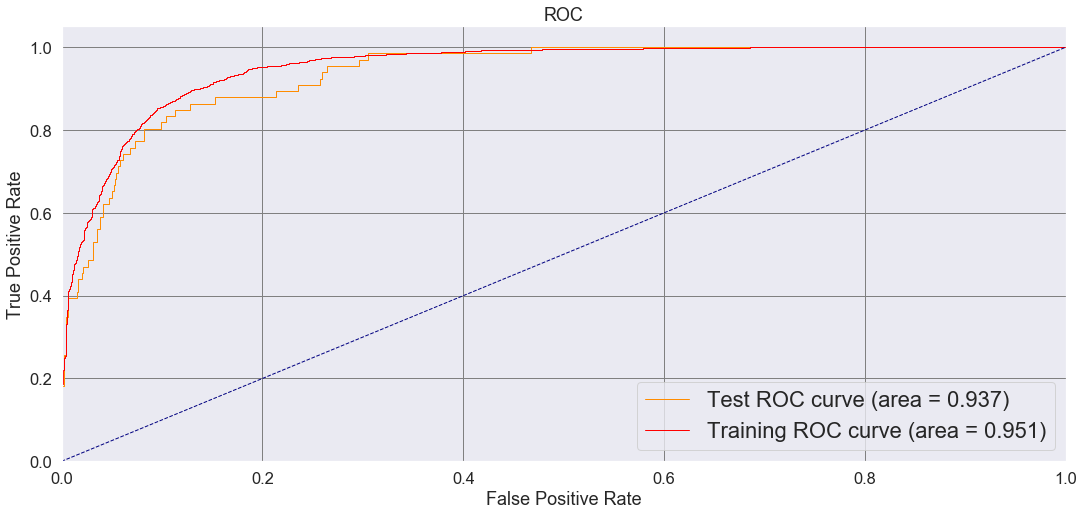

In [63]:
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


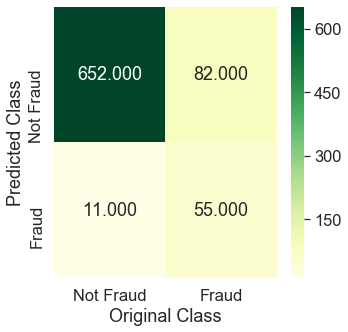

-------------------- Precision matrix  (Col Sum=1) --------------------


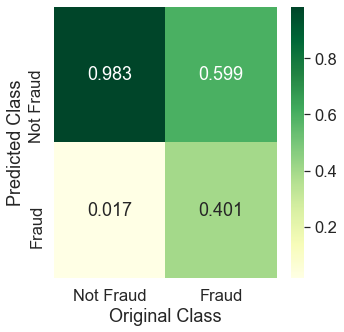

-------------------- Recall matrix  (Row Sum=1) - --------------------


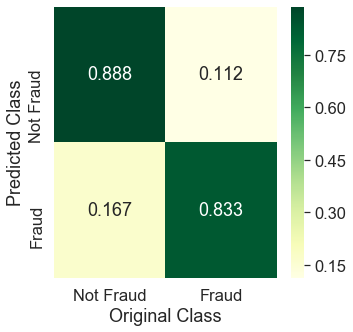

           Not Fraud     Fraud
Precision   0.983409  0.401460
Recall      0.888283  0.833333
F1-Score    0.933429  0.541872


In [64]:
conf_mat(pred,Y_test)

### Precision-Recall Curve

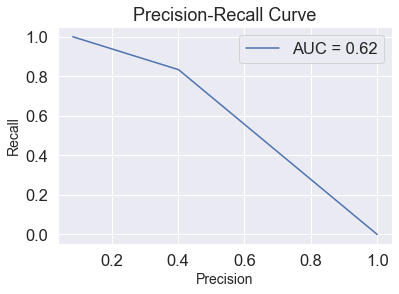

In [65]:
pr_recall_curve(Y_test, pred)

<h2> <font color = blue> 2. Random Forest
    

In [66]:
#Call the function to do cross validation (GridSearchCV) and return the scores correponding to different lamdba values
cv_scores_tr, cv_scores_cv, optimal_t= call_model(2,X_train, Y_train)

Best value of n_estimators =  300
0.989 (+/-0.010) for {'n_estimators': 50}
0.990 (+/-0.009) for {'n_estimators': 100}
0.990 (+/-0.010) for {'n_estimators': 200}
0.991 (+/-0.009) for {'n_estimators': 300}
0.991 (+/-0.010) for {'n_estimators': 500}


<h3> 'Training - Validation' AUC </h2>

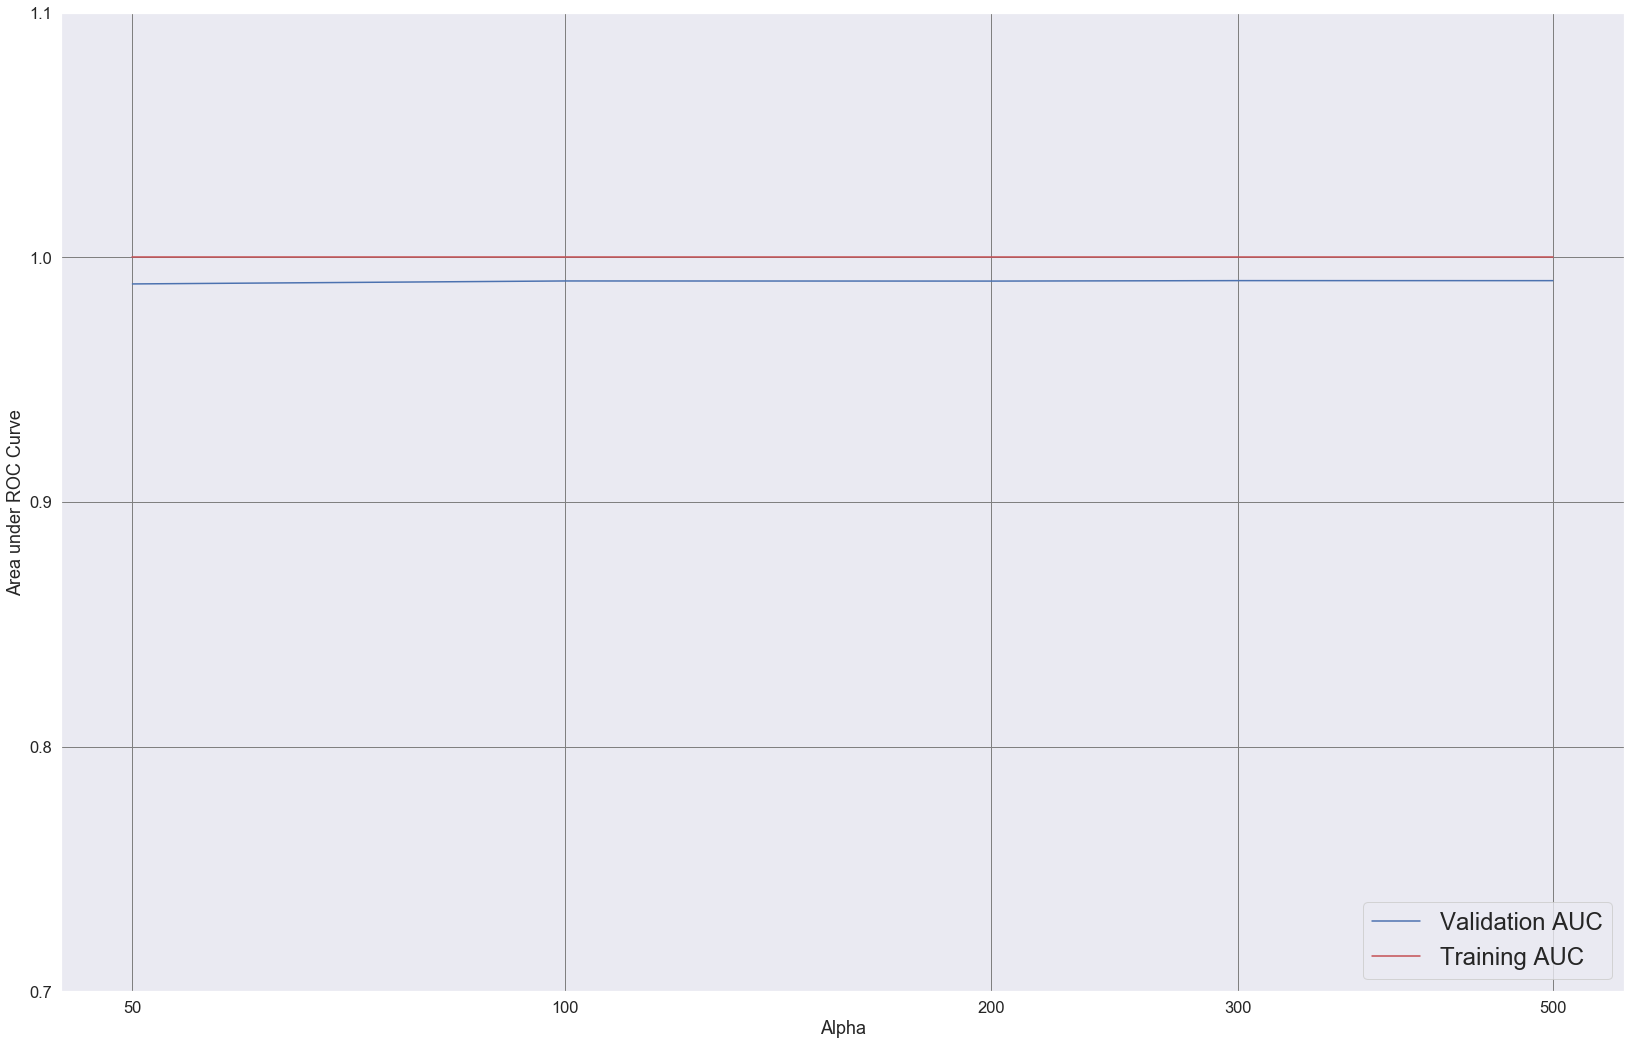

In [67]:
lambdalistorg = [50,100,200,300,500]
train_val_auc(cv_scores_tr, cv_scores_cv,lambdalistorg)

In [68]:
# Calculating the Test accuracy by calling the function test_acc
lrmodel,pred, fpr_ts, tpr_ts,fpr_tr, tpr_tr = test_acc(2,optimal_t,X_train,Y_train,X_test,Y_test)

<h3> ROC - AUC Curve </h3>

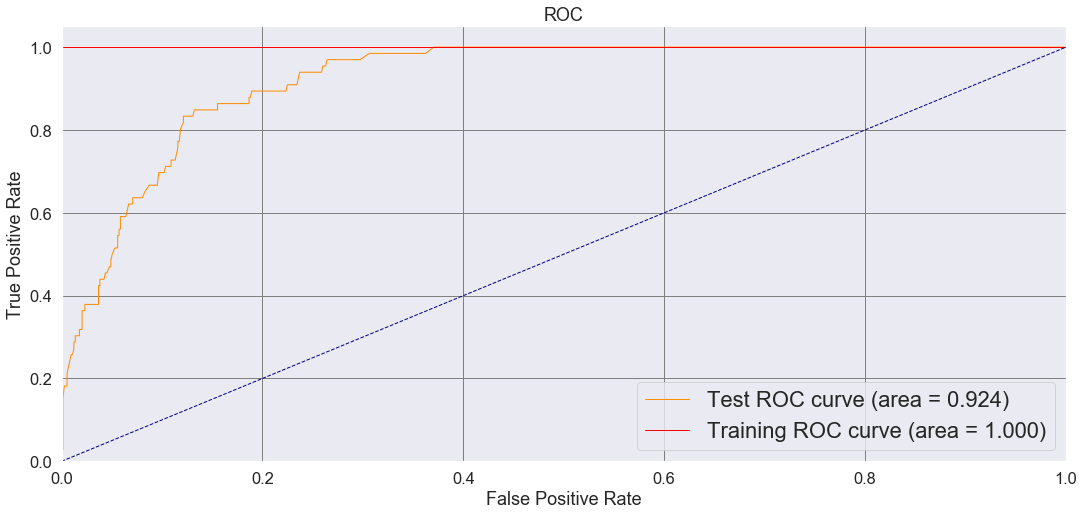

In [69]:
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


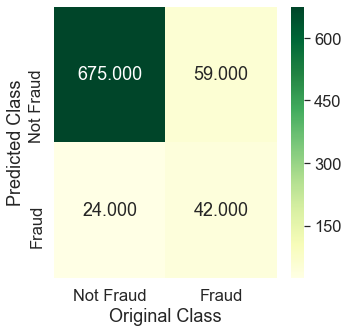

-------------------- Precision matrix  (Col Sum=1) --------------------


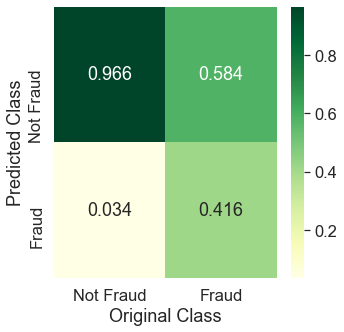

-------------------- Recall matrix  (Row Sum=1) - --------------------


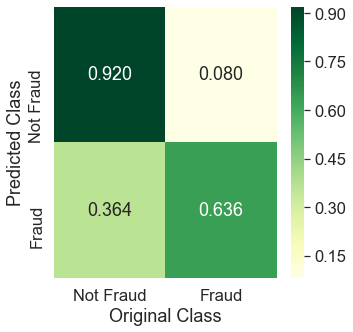

           Not Fraud     Fraud
Precision   0.965665  0.415842
Recall      0.919619  0.636364
F1-Score    0.942080  0.502994


In [70]:
conf_mat(pred,Y_test)

### Precision-Recall Curve

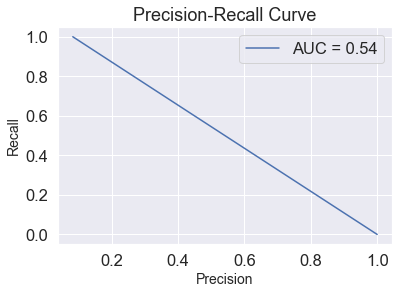

In [71]:
pr_recall_curve(Y_test, pred)

<h2> <font color = blue> 3. SVM

In [72]:
#Call the function to do cross validation (GridSearchCV) and return the scores correponding to different lamdba values
cv_scores_tr, cv_scores_cv, optimal_c= call_model(3,X_train, Y_train)

Best value of gamma =  1
0.941 (+/-0.014) for {'gamma': 0.001}
0.952 (+/-0.015) for {'gamma': 0.01}
0.958 (+/-0.017) for {'gamma': 0.1}
0.989 (+/-0.009) for {'gamma': 1}


<h3> 'Training - Validation' AUC </h2>

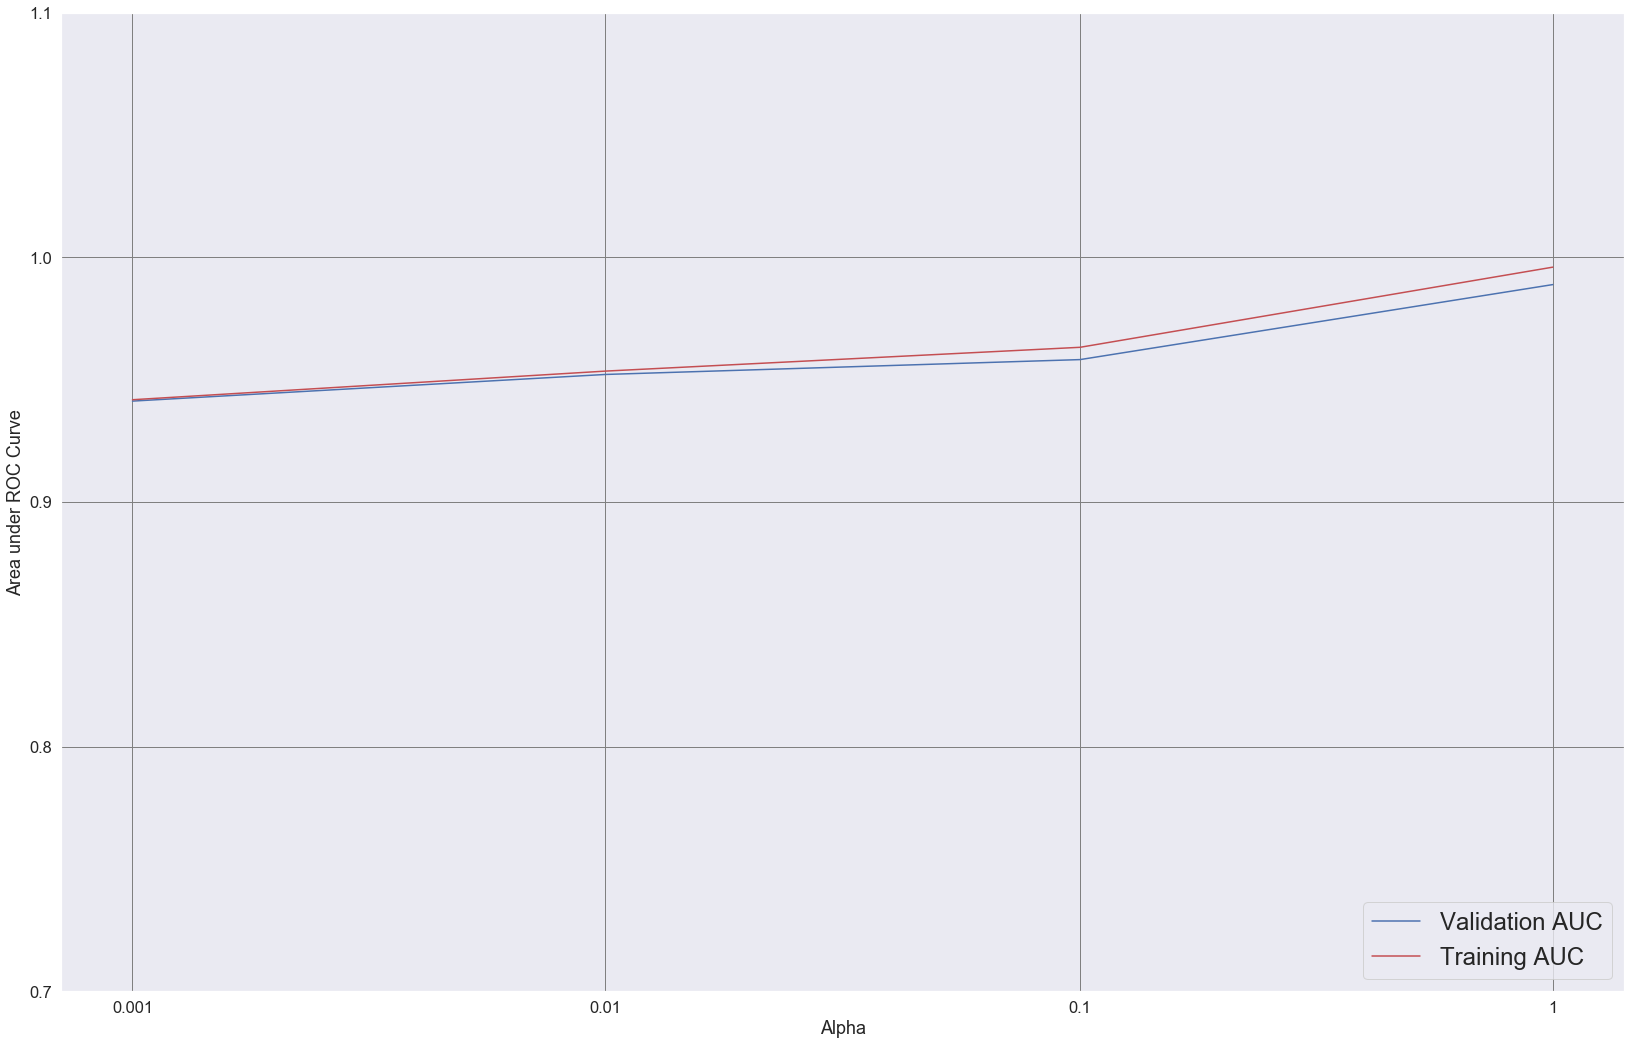

In [73]:
lambdalistorg = [0.001, 0.01, 0.1, 1]
train_val_auc(cv_scores_tr, cv_scores_cv,lambdalistorg)

In [74]:
# Calculating the Test accuracy by calling the function test_acc
lrmodel,pred, fpr_ts, tpr_ts,fpr_tr, tpr_tr = test_acc(3,optimal_c,X_train,Y_train,X_test,Y_test)

<h3> ROC - AUC Curve </h3>

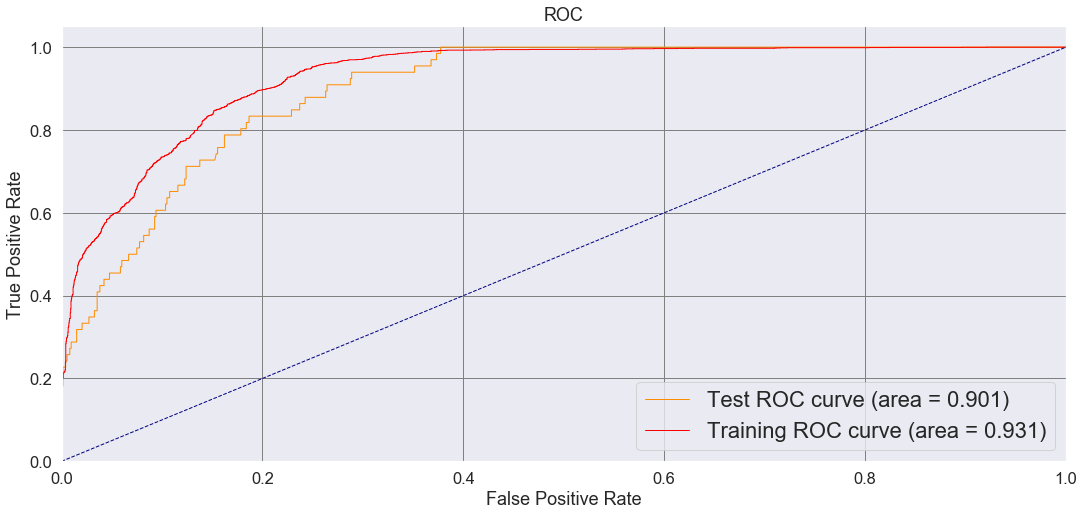

In [75]:
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


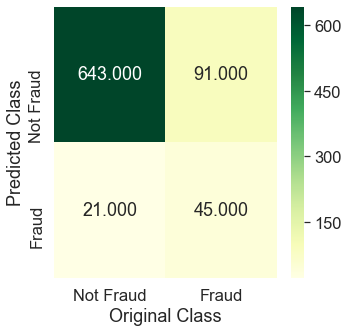

-------------------- Precision matrix  (Col Sum=1) --------------------


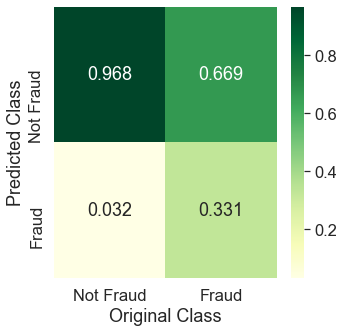

-------------------- Recall matrix  (Row Sum=1) - --------------------


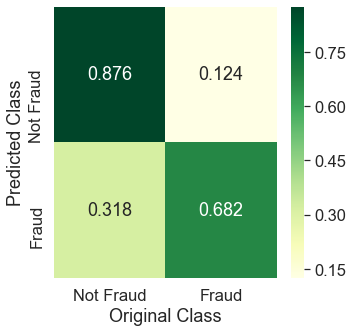

           Not Fraud     Fraud
Precision   0.968373  0.330882
Recall      0.876022  0.681818
F1-Score    0.919886  0.445545


In [76]:
conf_mat(pred,Y_test)

### Precision-Recall Curve

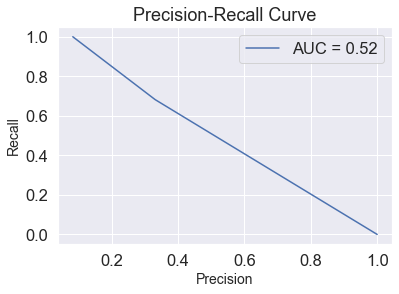

In [77]:
pr_recall_curve(Y_test, pred)

<h2> <font color = blue> 4. KNN

In [78]:
#Call the function to do cross validation (GridSearchCV) and return the scores correponding to different lamdba values
cv_scores_tr, cv_scores_cv, optimal_c= call_model(4,X_train, Y_train)

Best value of n_neighbors =  11
0.950 (+/-0.010) for {'n_neighbors': 1}
0.966 (+/-0.013) for {'n_neighbors': 3}
0.972 (+/-0.011) for {'n_neighbors': 5}
0.974 (+/-0.012) for {'n_neighbors': 7}
0.974 (+/-0.013) for {'n_neighbors': 9}
0.976 (+/-0.010) for {'n_neighbors': 11}
0.975 (+/-0.011) for {'n_neighbors': 13}
0.973 (+/-0.011) for {'n_neighbors': 15}
0.971 (+/-0.010) for {'n_neighbors': 17}


<h3> 'Training - Validation' AUC </h2>

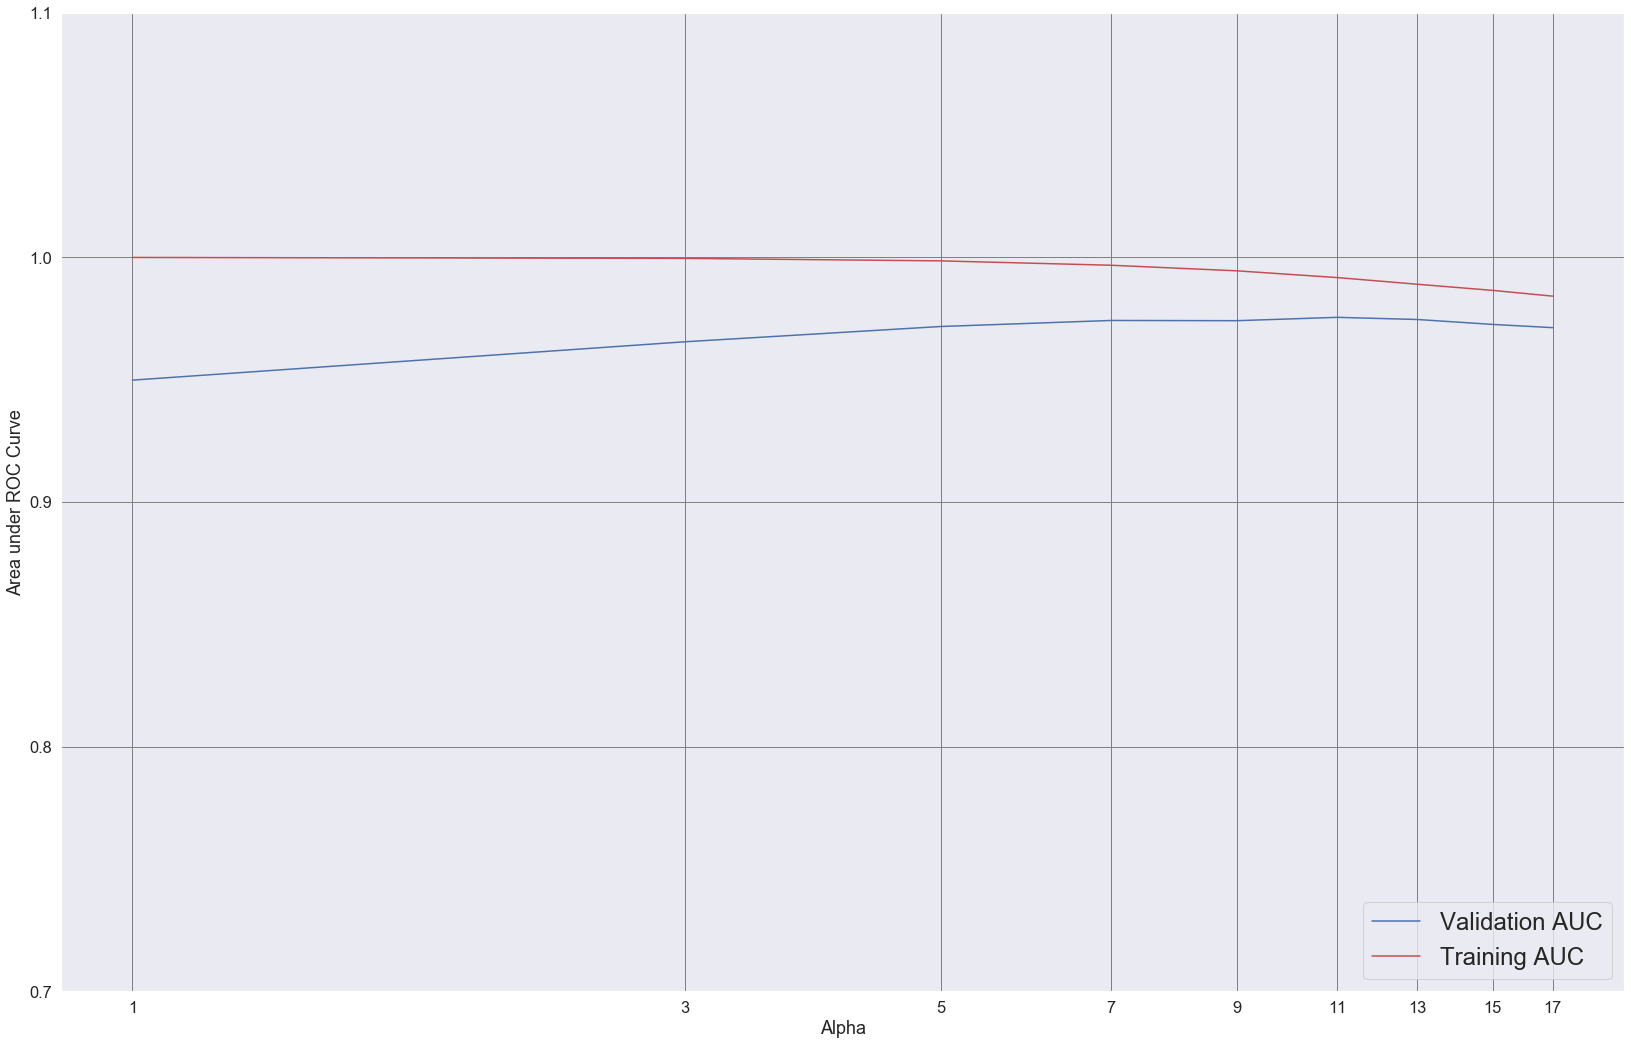

In [79]:
lambdalistorg = [1, 3, 5, 7, 9, 11, 13, 15, 17]
train_val_auc(cv_scores_tr, cv_scores_cv,lambdalistorg)

In [80]:
# Calculating the Test accuracy by calling the function test_acc
lrmodel,pred, fpr_ts, tpr_ts,fpr_tr, tpr_tr = test_acc(4,optimal_c,X_train,Y_train,X_test,Y_test)

<h3> ROC - AUC Curve </h3>

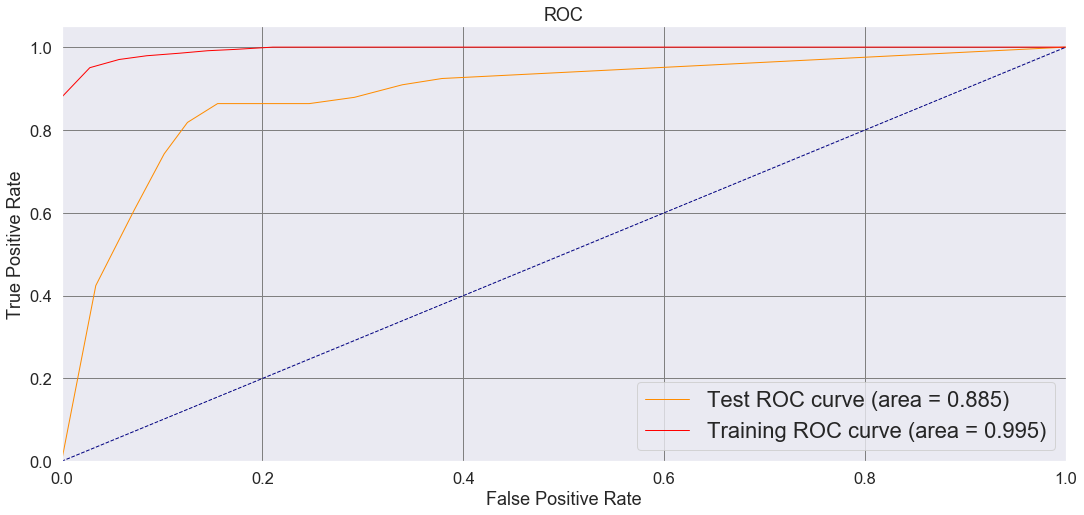

In [81]:
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


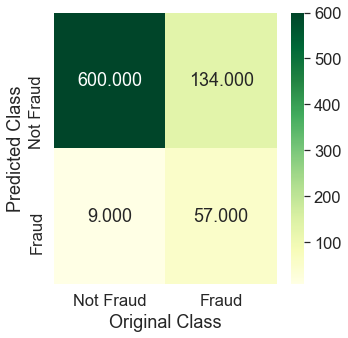

-------------------- Precision matrix  (Col Sum=1) --------------------


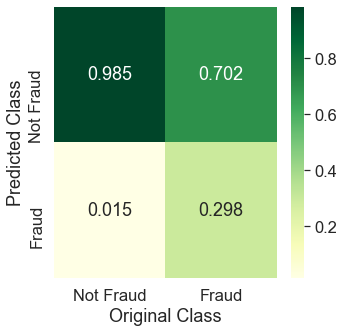

-------------------- Recall matrix  (Row Sum=1) - --------------------


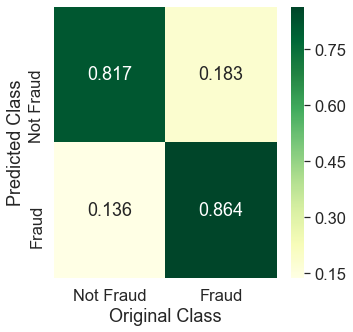

           Not Fraud     Fraud
Precision   0.985222  0.298429
Recall      0.817439  0.863636
F1-Score    0.893522  0.443580


In [82]:
conf_mat(pred,Y_test)

### Precision-Recall Curve

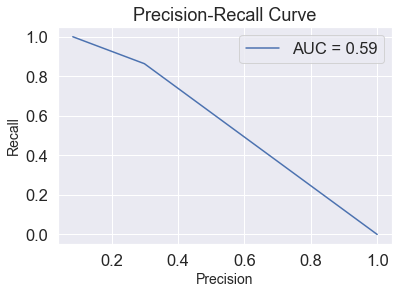

In [83]:
pr_recall_curve(Y_test, pred)

<h2> <font color = blue> 5. Neural Network

In [84]:
model = Sequential()
model.add(Dense(64, input_shape = (17,), activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(1, activation = 'sigmoid'))
sgd = adam(lr = 0.001)
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1152      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [85]:
%%time
model.fit(X_train, Y_train, batch_size = 128, epochs = 100, verbose = 1)

Epoch 1/100
5762/5762 [==============================] - 3s 606us/step - loss: 0.5243 - accuracy: 0.7520
Epoch 2/100
5762/5762 [==============================] - 1s 117us/step - loss: 0.3874 - accuracy: 0.8376
Epoch 3/100
5762/5762 [==============================] - 1s 116us/step - loss: 0.3782 - accuracy: 0.8443
Epoch 4/100
5762/5762 [==============================] - 1s 122us/step - loss: 0.3666 - accuracy: 0.8468
Epoch 5/100
5762/5762 [==============================] - 1s 125us/step - loss: 0.3575 - accuracy: 0.8514
Epoch 6/100
5762/5762 [==============================] - 1s 130us/step - loss: 0.3508 - accuracy: 0.8544
Epoch 7/100
5762/5762 [==============================] - 1s 135us/step - loss: 0.3410 - accuracy: 0.8572
Epoch 8/100
5762/5762 [==============================] - 1s 140us/step - loss: 0.3428 - accuracy: 0.8554
Epoch 9/100
5762/5762 [==============================] - 1s 141us/step - loss: 0.3448 - accuracy: 0.8560
Epoch 10/100
5762/5762 [==============================]

5762/5762 [==============================] - 1s 206us/step - loss: 0.2854 - accuracy: 0.8853
Epoch 79/100
5762/5762 [==============================] - 1s 206us/step - loss: 0.2845 - accuracy: 0.8853
Epoch 80/100
5762/5762 [==============================] - 1s 205us/step - loss: 0.2742 - accuracy: 0.8964
Epoch 81/100
5762/5762 [==============================] - 1s 205us/step - loss: 0.2772 - accuracy: 0.8917
Epoch 82/100
5762/5762 [==============================] - 1s 204us/step - loss: 0.2816 - accuracy: 0.8849
Epoch 83/100
5762/5762 [==============================] - 1s 206us/step - loss: 0.2786 - accuracy: 0.8900
Epoch 84/100
5762/5762 [==============================] - 1s 214us/step - loss: 0.2771 - accuracy: 0.8898
Epoch 85/100
5762/5762 [==============================] - 1s 215us/step - loss: 0.2794 - accuracy: 0.8882
Epoch 86/100
5762/5762 [==============================] - 1s 215us/step - loss: 0.2778 - accuracy: 0.8884
Epoch 87/100
5762/5762 [==============================] - 1

In [86]:
results = model.evaluate(X_test, Y_test)


800/800 [==============================] - 1s 1ms/step


In [87]:
print(model.metrics_names)
print(results)    

['loss', 'accuracy']
[0.2852050858736038, 0.8675000071525574]


<h3> ROC - AUC Curve </h3>

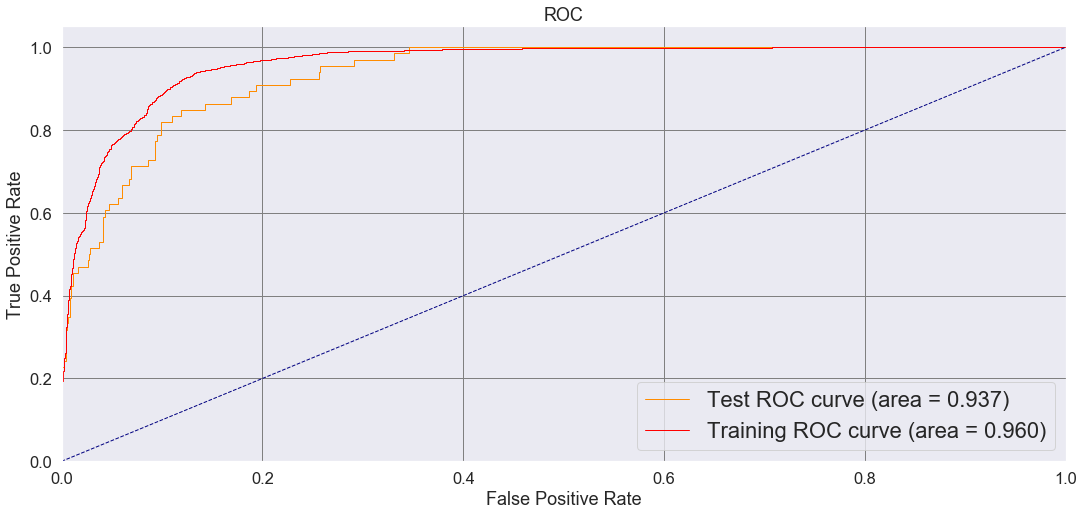

In [88]:
# predict the response Probabilities for Test data
pred_prob_ts = model.predict_proba(X_test)
# AUC for Test data
fpr_ts, tpr_ts, threshold = roc_curve(Y_test, pred_prob_ts)     

# predict the response Probabilities for Training data
pred_prob_tr = model.predict_proba(X_train)
# AUC for Training data
fpr_tr, tpr_tr, threshold = roc_curve(Y_train, pred_prob_tr)  
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


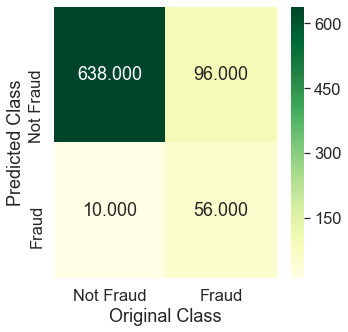

-------------------- Precision matrix  (Col Sum=1) --------------------


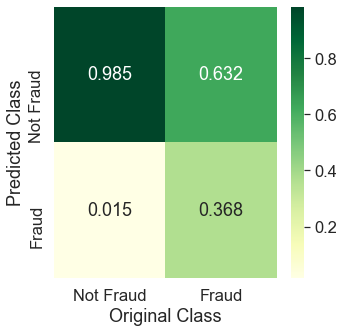

-------------------- Recall matrix  (Row Sum=1) - --------------------


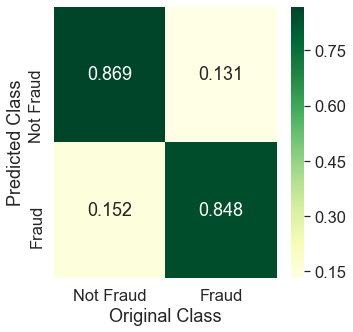

           Not Fraud     Fraud
Precision   0.984568  0.368421
Recall      0.869210  0.848485
F1-Score    0.923300  0.513761


In [89]:
Y_pred_cls = model.predict_classes(X_test, batch_size=200, verbose=0)
conf_mat(Y_pred_cls,Y_test)

### Precision-Recall Curve

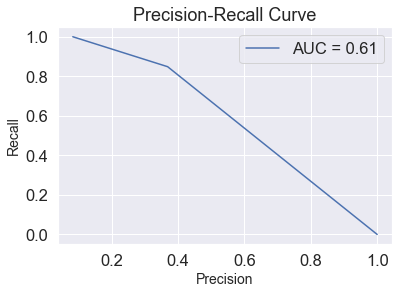

In [90]:
pr_recall_curve(Y_test, Y_pred_cls)

In [91]:
x = PrettyTable()

x.field_names = ["Oversampling","Model", "Test-AUC","Precision-Recall AUC"]

x.add_row(["No", "Logistic Regression", 0.925 ,0.54])
x.add_row(["No", "Random Forest", 0.924 ,0.54])
x.add_row(["No", "SVM",0.935 ,0.54])
x.add_row(["No", "KNN", 0.894,0.58])
x.add_row(["No", "Neural Network", 0.883 ,.54])
x.add_row(["Yes", "Logistic Regression", 0.935 ,0.62])
x.add_row(["Yes", "Random Forest", 0.925 ,0.56])
x.add_row(["Yes", "SVM", 0.901,0.52])
x.add_row(["Yes", "KNN", 0.885 ,0.59])
x.add_row(["Yes", "Neural Network", 0.943,0.58])
print(x)

+--------------+---------------------+----------+----------------------+
| Oversampling |        Model        | Test-AUC | Precision-Recall AUC |
+--------------+---------------------+----------+----------------------+
|      No      | Logistic Regression |  0.925   |         0.54         |
|      No      |    Random Forest    |  0.924   |         0.54         |
|      No      |         SVM         |  0.935   |         0.54         |
|      No      |         KNN         |  0.894   |         0.58         |
|      No      |    Neural Network   |  0.883   |         0.54         |
|     Yes      | Logistic Regression |  0.935   |         0.62         |
|     Yes      |    Random Forest    |  0.925   |         0.56         |
|     Yes      |         SVM         |  0.901   |         0.52         |
|     Yes      |         KNN         |  0.885   |         0.59         |
|     Yes      |    Neural Network   |  0.943   |         0.58         |
+--------------+---------------------+----------+--

## Applying the results in unlablled Test Data (Chosen Model : Nueral Networks WITH Oversampling)

In [92]:
test_data.head()

,Provider_ID,Total Deductible Amount,Avg Deductible Amount,Total Insurance Amount,Avg Insurance Amount,Avg Days Stayed,Avg Days in claim,Avg Days Admission to Claim,Avg Age,Avg Diagnosis Count,Avg Procedure Count,Avg Months PartA Cov,Avg Months PartB Cov,Avg IP ReimbursementAmt,Avg OP ReimbursementAmt,Avg IP DeductibleAmt,Avg OP DeductibleAmt,Avg Disease Count,Provider
index,,,,,,,,,,,,,,,,,,,
0,PRV56004,50.0,10.000000,3470,694.000000,4.000000,4.000000,0.0,79.400000,2.600000,0.000000,12.000000,12.000000,22606.000000,5996.000000,854.400000,1562.000000,4.200000,PRV56004
1,PRV56005,2166.0,29.270270,31660,427.837838,1.283784,1.283784,0.0,76.945946,2.581081,0.000000,12.000000,12.000000,4876.756757,1436.216216,418.540541,465.405405,4.486486,PRV56005
2,PRV56006,3170.0,2.908257,289380,265.486239,1.364220,1.364220,0.0,75.766055,2.586239,0.000000,11.845872,11.964220,4274.376147,1969.935780,509.533945,591.688073,4.309174,PRV56006
3,PRV56007,73692.0,909.777778,836930,10332.469136,4.950617,4.950617,0.0,74.641975,7.469136,0.716049,11.703704,11.913580,18097.407407,3073.703704,1632.444444,755.185185,5.135802,PRV56007
4,PRV56008,4080.0,2.978102,476600,347.883212,1.516788,1.516788,0.0,75.672263,2.480292,0.000730,11.991241,11.964964,3647.233577,2835.313869,394.032117,682.474453,4.413139,PRV56008


In [93]:
Test_Set = test_data[['Total Deductible Amount', 'Avg Deductible Amount',
       'Total Insurance Amount', 'Avg Insurance Amount', 'Avg Days Stayed',
       'Avg Days in claim', 'Avg Days Admission to Claim', 'Avg Age',
       'Avg Diagnosis Count', 'Avg Procedure Count', 'Avg Months PartA Cov',
       'Avg Months PartB Cov', 'Avg IP ReimbursementAmt',
       'Avg OP ReimbursementAmt', 'Avg IP DeductibleAmt',
       'Avg OP DeductibleAmt', 'Avg Disease Count']]

Test_Set = X_train_std.transform(Test_Set)

print(Test_Set.shape)

(1412, 17)


In [94]:
Final_Prediction = model.predict_classes(Test_Set, batch_size=200, verbose=0)
print(Final_Prediction.shape)
test_data['Fraud'] = Final_Prediction
test_data.loc[test_data.Fraud == 1,'Fraud'] = 'Yes'
test_data.loc[test_data.Fraud == 0,'Fraud'] = 'No'
test_data.head()

(1412, 1)


,Provider_ID,Total Deductible Amount,Avg Deductible Amount,Total Insurance Amount,Avg Insurance Amount,Avg Days Stayed,Avg Days in claim,Avg Days Admission to Claim,Avg Age,Avg Diagnosis Count,Avg Procedure Count,Avg Months PartA Cov,Avg Months PartB Cov,Avg IP ReimbursementAmt,Avg OP ReimbursementAmt,Avg IP DeductibleAmt,Avg OP DeductibleAmt,Avg Disease Count,Provider,Fraud
index,,,,,,,,,,,,,,,,,,,,
0,PRV56004,50.0,10.000000,3470,694.000000,4.000000,4.000000,0.0,79.400000,2.600000,0.000000,12.000000,12.000000,22606.000000,5996.000000,854.400000,1562.000000,4.200000,PRV56004,No
1,PRV56005,2166.0,29.270270,31660,427.837838,1.283784,1.283784,0.0,76.945946,2.581081,0.000000,12.000000,12.000000,4876.756757,1436.216216,418.540541,465.405405,4.486486,PRV56005,No
2,PRV56006,3170.0,2.908257,289380,265.486239,1.364220,1.364220,0.0,75.766055,2.586239,0.000000,11.845872,11.964220,4274.376147,1969.935780,509.533945,591.688073,4.309174,PRV56006,Yes
3,PRV56007,73692.0,909.777778,836930,10332.469136,4.950617,4.950617,0.0,74.641975,7.469136,0.716049,11.703704,11.913580,18097.407407,3073.703704,1632.444444,755.185185,5.135802,PRV56007,Yes
4,PRV56008,4080.0,2.978102,476600,347.883212,1.516788,1.516788,0.0,75.672263,2.480292,0.000730,11.991241,11.964964,3647.233577,2835.313869,394.032117,682.474453,4.413139,PRV56008,Yes


In [95]:
test_data.Fraud.value_counts()

No     1181
Yes     231
Name: Fraud, dtype: int64

In [96]:
test_data[['Provider_ID','Fraud']].to_excel('Test_data.xls', index=False)